In [1]:
import sys
sys.path.append("..")

In [2]:
from datasets import Dataset
import torch
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import (
    Compose,
    Normalize,
    ToTensor
)

c:\app\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir('..')
print(os.getcwd())

c:\Users\z0224841\PycharmProjects\SIAP\EGG-Sentiment-Classification


In [4]:
def dataset_generator():
    """
    Generator for datasets 

    Parametrs:
    path (str) : path to folder
    """
    labels: list = ["Disgust", "Fear", "Sad", "Netural", "Happy"]
    for file in os.listdir("spectrograms"):
        tokens: list = file.split("_")
        label: int = int(tokens[1])
        spectrogram: np.array = np.load(os.path.join('spectrograms', file))
        spectrogram = 10*np.log10(spectrogram)
        spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram)) * 255
        spectrogram = spectrogram.astype(np.uint8)
        spectrogram = Image.fromarray(spectrogram, mode="L")
        yield {
            "img": spectrogram,
            "label": labels[label] 
        }

dataset = Dataset.from_generator(dataset_generator)
dataset = dataset.class_encode_column("label")

In [5]:
id2label = {id:label for id, label in enumerate(dataset.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Disgust', 1: 'Fear', 2: 'Happy', 3: 'Netural', 4: 'Sad'}

In [6]:
splits_train_test = dataset.train_test_split(test_size = 0.3)
train_ds = splits_train_test['train']
val_test_ds = splits_train_test['test']
test_ds = val_test_ds.train_test_split(test_size=0.5)['train']
val_ds = val_test_ds.train_test_split(test_size=0.5)['test']

In [7]:
_ds_transform = Compose([
    ToTensor()
])

def ds_transform(examples):
    examples['img'] = [_ds_transform(image.convert("L")) for image in examples['img']]
    return examples

train_ds.set_transform(ds_transform)
test_ds.set_transform(ds_transform)
val_ds.set_transform(ds_transform)

## ViT implementation


In [8]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [9]:
#Hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 500
LEARNING_RATE = .0001
PATCH_SIZE = 16
IMG_SIZE = 64
IN_CHANNELS = 1
NUM_HEADS = 16
DROPOUT = .0001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
NUM_CLASSES = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x


In [11]:
class ViT(nn.Module):

    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
            super().__init__()
            self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
            
            encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
            self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

            self.mlp_head = nn.Sequential(
                nn.LayerNorm(normalized_shape=embed_dim),
                nn.Linear(in_features=embed_dim, out_features=num_classes),
                nn.Softmax(dim=-1)
            )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x


model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 64, 64).to(device)
print(model(x))

c:\app\Python39\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[0.2984, 0.0900, 0.0779, 0.4428, 0.0908],
        [0.2737, 0.0908, 0.0830, 0.4485, 0.1041],
        [0.3063, 0.0984, 0.0806, 0.4418, 0.0729],
        ...,
        [0.2731, 0.0971, 0.0805, 0.4699, 0.0793],
        [0.3140, 0.0907, 0.0781, 0.4350, 0.0822],
        [0.3103, 0.0965, 0.0772, 0.4359, 0.0801]], grad_fn=<SoftmaxBackward0>)


In [12]:
train_dataloader = DataLoader(dataset=train_ds,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_ds,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_ds,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["img"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["img"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

save_path = 'vit_model_v2.pth'
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
}, save_path)

print(f"Model saved to {save_path}")


  0%|          | 1/500 [01:45<14:36:49, 105.43s/it]

------------------------------
Train Loss EPOCH 1: 1.6016
Valid Loss EPOCH 1: 1.5997
Train Accuracy EPOCH 1: 0.2404
Valid Accuracy EPOCH 1: 0.2495
------------------------------


  0%|          | 2/500 [03:28<14:23:37, 104.05s/it]

------------------------------
Train Loss EPOCH 2: 1.5994
Valid Loss EPOCH 2: 1.5958
Train Accuracy EPOCH 2: 0.2435
Valid Accuracy EPOCH 2: 0.2495
------------------------------


  1%|          | 3/500 [05:09<14:10:50, 102.72s/it]

------------------------------
Train Loss EPOCH 3: 1.5989
Valid Loss EPOCH 3: 1.5952
Train Accuracy EPOCH 3: 0.2461
Valid Accuracy EPOCH 3: 0.2488
------------------------------


  1%|          | 4/500 [06:51<14:05:25, 102.27s/it]

------------------------------
Train Loss EPOCH 4: 1.5991
Valid Loss EPOCH 4: 1.5967
Train Accuracy EPOCH 4: 0.2449
Valid Accuracy EPOCH 4: 0.2495
------------------------------


  1%|          | 5/500 [08:32<14:00:12, 101.84s/it]

------------------------------
Train Loss EPOCH 5: 1.5986
Valid Loss EPOCH 5: 1.5904
Train Accuracy EPOCH 5: 0.2472
Valid Accuracy EPOCH 5: 0.2644
------------------------------


  1%|          | 6/500 [10:13<13:57:07, 101.67s/it]

------------------------------
Train Loss EPOCH 6: 1.5968
Valid Loss EPOCH 6: 1.5916
Train Accuracy EPOCH 6: 0.2485
Valid Accuracy EPOCH 6: 0.2662
------------------------------


100%|██████████| 189/189 [00:06<00:00, 27.63it/s]


------------------------------
Train Loss EPOCH 7: 1.5937
Valid Loss EPOCH 7: 1.5867


  1%|▏         | 7/500 [11:59<14:06:04, 102.97s/it]

Train Accuracy EPOCH 7: 0.2538
Valid Accuracy EPOCH 7: 0.2773
------------------------------


100%|██████████| 189/189 [00:07<00:00, 24.13it/s]


------------------------------
Train Loss EPOCH 8: 1.5918
Valid Loss EPOCH 8: 1.5875
Train Accuracy EPOCH 8: 0.2596


  2%|▏         | 8/500 [13:48<14:21:36, 105.07s/it]

Valid Accuracy EPOCH 8: 0.2770
------------------------------


100%|██████████| 189/189 [00:06<00:00, 30.06it/s]


------------------------------
Train Loss EPOCH 9: 1.5902
Valid Loss EPOCH 9: 1.5883
Train Accuracy EPOCH 9: 0.2610


  2%|▏         | 9/500 [15:35<14:22:37, 105.41s/it]

Valid Accuracy EPOCH 9: 0.2788
------------------------------


100%|██████████| 189/189 [00:06<00:00, 30.57it/s]


------------------------------
Train Loss EPOCH 10: 1.5900
Valid Loss EPOCH 10: 1.5862
Train Accuracy EPOCH 10: 0.2622


  2%|▏         | 10/500 [17:15<14:09:29, 104.02s/it]

Valid Accuracy EPOCH 10: 0.2714
------------------------------


100%|██████████| 189/189 [00:07<00:00, 26.99it/s]


------------------------------
Train Loss EPOCH 11: 1.5881
Valid Loss EPOCH 11: 1.5836
Train Accuracy EPOCH 11: 0.2674


  2%|▏         | 11/500 [18:59<14:05:46, 103.78s/it]

Valid Accuracy EPOCH 11: 0.2770
------------------------------


100%|██████████| 189/189 [00:06<00:00, 28.79it/s]


------------------------------
Train Loss EPOCH 12: 1.5889
Valid Loss EPOCH 12: 1.5865
Train Accuracy EPOCH 12: 0.2646


  2%|▏         | 12/500 [20:46<14:12:52, 104.86s/it]

Valid Accuracy EPOCH 12: 0.2729
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.25it/s]


------------------------------
Train Loss EPOCH 13: 1.5875
Valid Loss EPOCH 13: 1.5820


  3%|▎         | 13/500 [22:28<14:03:24, 103.91s/it]

Train Accuracy EPOCH 13: 0.2652
Valid Accuracy EPOCH 13: 0.2763
------------------------------


  3%|▎         | 14/500 [24:03<13:39:32, 101.18s/it]

------------------------------
Train Loss EPOCH 14: 1.5856
Valid Loss EPOCH 14: 1.5818
Train Accuracy EPOCH 14: 0.2703
Valid Accuracy EPOCH 14: 0.2810
------------------------------


  3%|▎         | 15/500 [25:20<12:38:44, 93.86s/it] 

------------------------------
Train Loss EPOCH 15: 1.5846
Valid Loss EPOCH 15: 1.5795
Train Accuracy EPOCH 15: 0.2718
Valid Accuracy EPOCH 15: 0.2802
------------------------------


  3%|▎         | 16/500 [26:34<11:51:14, 88.17s/it]

------------------------------
Train Loss EPOCH 16: 1.5839
Valid Loss EPOCH 16: 1.5813
Train Accuracy EPOCH 16: 0.2713
Valid Accuracy EPOCH 16: 0.2710
------------------------------


  3%|▎         | 17/500 [27:52<11:24:55, 85.08s/it]

------------------------------
Train Loss EPOCH 17: 1.5824
Valid Loss EPOCH 17: 1.5931
Train Accuracy EPOCH 17: 0.2726
Valid Accuracy EPOCH 17: 0.2649
------------------------------


  4%|▎         | 18/500 [29:10<11:06:43, 83.00s/it]

------------------------------
Train Loss EPOCH 18: 1.5843
Valid Loss EPOCH 18: 1.5811
Train Accuracy EPOCH 18: 0.2722
Valid Accuracy EPOCH 18: 0.2838
------------------------------


  4%|▍         | 19/500 [30:29<10:55:43, 81.79s/it]

------------------------------
Train Loss EPOCH 19: 1.5802
Valid Loss EPOCH 19: 1.5759
Train Accuracy EPOCH 19: 0.2775
Valid Accuracy EPOCH 19: 0.2883
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.05it/s]


------------------------------
Train Loss EPOCH 20: 1.5783
Valid Loss EPOCH 20: 1.5766
Train Accuracy EPOCH 20: 0.2803
Valid Accuracy EPOCH 20: 0.2811
------------------------------


  4%|▍         | 21/500 [33:00<10:23:57, 78.16s/it]

------------------------------
Train Loss EPOCH 21: 1.5765
Valid Loss EPOCH 21: 1.5775
Train Accuracy EPOCH 21: 0.2851
Valid Accuracy EPOCH 21: 0.2828
------------------------------


  4%|▍         | 22/500 [34:18<10:22:50, 78.18s/it]

------------------------------
Train Loss EPOCH 22: 1.5751
Valid Loss EPOCH 22: 1.5736
Train Accuracy EPOCH 22: 0.2872
Valid Accuracy EPOCH 22: 0.2921
------------------------------


  5%|▍         | 23/500 [35:32<10:11:24, 76.91s/it]

------------------------------
Train Loss EPOCH 23: 1.5729
Valid Loss EPOCH 23: 1.5731
Train Accuracy EPOCH 23: 0.2937
Valid Accuracy EPOCH 23: 0.2898
------------------------------


  5%|▍         | 24/500 [36:49<10:09:10, 76.79s/it]

------------------------------
Train Loss EPOCH 24: 1.5698
Valid Loss EPOCH 24: 1.5824
Train Accuracy EPOCH 24: 0.2969
Valid Accuracy EPOCH 24: 0.2802
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.30it/s]


------------------------------
Train Loss EPOCH 25: 1.5676
Valid Loss EPOCH 25: 1.5751
Train Accuracy EPOCH 25: 0.3002
Valid Accuracy EPOCH 25: 0.2846
------------------------------


  5%|▌         | 26/500 [39:22<10:06:07, 76.72s/it]

------------------------------
Train Loss EPOCH 26: 1.5637
Valid Loss EPOCH 26: 1.5678
Train Accuracy EPOCH 26: 0.3042
Valid Accuracy EPOCH 26: 0.2962
------------------------------


  5%|▌         | 27/500 [40:56<10:46:47, 82.05s/it]

------------------------------
Train Loss EPOCH 27: 1.5614
Valid Loss EPOCH 27: 1.5747
Train Accuracy EPOCH 27: 0.3045
Valid Accuracy EPOCH 27: 0.2863
------------------------------


  6%|▌         | 28/500 [42:22<10:55:26, 83.32s/it]

------------------------------
Train Loss EPOCH 28: 1.5568
Valid Loss EPOCH 28: 1.5676
Train Accuracy EPOCH 28: 0.3138
Valid Accuracy EPOCH 28: 0.2964
------------------------------


100%|██████████| 189/189 [00:04<00:00, 42.30it/s]


------------------------------
Train Loss EPOCH 29: 1.5537
Valid Loss EPOCH 29: 1.5647
Train Accuracy EPOCH 29: 0.3180
Valid Accuracy EPOCH 29: 0.3077
------------------------------


  6%|▌         | 30/500 [44:57<10:26:16, 79.95s/it]

------------------------------
Train Loss EPOCH 30: 1.5472
Valid Loss EPOCH 30: 1.5635
Train Accuracy EPOCH 30: 0.3253
Valid Accuracy EPOCH 30: 0.3072
------------------------------


  6%|▌         | 31/500 [46:15<10:22:33, 79.64s/it]

------------------------------
Train Loss EPOCH 31: 1.5423
Valid Loss EPOCH 31: 1.5517
Train Accuracy EPOCH 31: 0.3304
Valid Accuracy EPOCH 31: 0.3219
------------------------------


  6%|▋         | 32/500 [47:40<10:31:46, 81.00s/it]

------------------------------
Train Loss EPOCH 32: 1.5371
Valid Loss EPOCH 32: 1.5491
Train Accuracy EPOCH 32: 0.3352
Valid Accuracy EPOCH 32: 0.3204
------------------------------


  7%|▋         | 33/500 [49:02<10:33:48, 81.43s/it]

------------------------------
Train Loss EPOCH 33: 1.5337
Valid Loss EPOCH 33: 1.5377
Train Accuracy EPOCH 33: 0.3443
Valid Accuracy EPOCH 33: 0.3406
------------------------------


  7%|▋         | 34/500 [50:23<10:31:58, 81.37s/it]

------------------------------
Train Loss EPOCH 34: 1.5247
Valid Loss EPOCH 34: 1.5282
Train Accuracy EPOCH 34: 0.3544
Valid Accuracy EPOCH 34: 0.3502
------------------------------


  7%|▋         | 35/500 [51:45<10:30:55, 81.41s/it]

------------------------------
Train Loss EPOCH 35: 1.5188
Valid Loss EPOCH 35: 1.5196
Train Accuracy EPOCH 35: 0.3612
Valid Accuracy EPOCH 35: 0.3625
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.17it/s]


------------------------------
Train Loss EPOCH 36: 1.5129
Valid Loss EPOCH 36: 1.5263
Train Accuracy EPOCH 36: 0.3683


  7%|▋         | 36/500 [53:12<10:42:13, 83.05s/it]

Valid Accuracy EPOCH 36: 0.3526
------------------------------


  7%|▋         | 37/500 [54:34<10:39:51, 82.92s/it]

------------------------------
Train Loss EPOCH 37: 1.5068
Valid Loss EPOCH 37: 1.5206
Train Accuracy EPOCH 37: 0.3760
Valid Accuracy EPOCH 37: 0.3575
------------------------------


  8%|▊         | 38/500 [55:54<10:31:21, 82.00s/it]

------------------------------
Train Loss EPOCH 38: 1.4955
Valid Loss EPOCH 38: 1.5081
Train Accuracy EPOCH 38: 0.3884
Valid Accuracy EPOCH 38: 0.3756
------------------------------


  8%|▊         | 39/500 [57:14<10:25:33, 81.42s/it]

------------------------------
Train Loss EPOCH 39: 1.4903
Valid Loss EPOCH 39: 1.5184
Train Accuracy EPOCH 39: 0.3963
Valid Accuracy EPOCH 39: 0.3646
------------------------------


100%|██████████| 189/189 [00:05<00:00, 36.88it/s]


------------------------------
Train Loss EPOCH 40: 1.4850
Valid Loss EPOCH 40: 1.5037
Train Accuracy EPOCH 40: 0.4008
Valid Accuracy EPOCH 40: 0.3801
------------------------------


  8%|▊         | 41/500 [59:54<10:17:20, 80.70s/it]

------------------------------
Train Loss EPOCH 41: 1.4755
Valid Loss EPOCH 41: 1.5030
Train Accuracy EPOCH 41: 0.4122
Valid Accuracy EPOCH 41: 0.3832
------------------------------


  8%|▊         | 42/500 [1:01:15<10:15:19, 80.61s/it]

------------------------------
Train Loss EPOCH 42: 1.4700
Valid Loss EPOCH 42: 1.4943
Train Accuracy EPOCH 42: 0.4175
Valid Accuracy EPOCH 42: 0.3926
------------------------------


  9%|▊         | 43/500 [1:02:35<10:12:54, 80.47s/it]

------------------------------
Train Loss EPOCH 43: 1.4627
Valid Loss EPOCH 43: 1.4765
Train Accuracy EPOCH 43: 0.4251
Valid Accuracy EPOCH 43: 0.4097
------------------------------


  9%|▉         | 44/500 [1:03:54<10:09:50, 80.24s/it]

------------------------------
Train Loss EPOCH 44: 1.4577
Valid Loss EPOCH 44: 1.4748
Train Accuracy EPOCH 44: 0.4315
Valid Accuracy EPOCH 44: 0.4158
------------------------------


  9%|▉         | 45/500 [1:05:14<10:07:20, 80.09s/it]

------------------------------
Train Loss EPOCH 45: 1.4498
Valid Loss EPOCH 45: 1.4639
Train Accuracy EPOCH 45: 0.4409
Valid Accuracy EPOCH 45: 0.4253
------------------------------


  9%|▉         | 46/500 [1:06:32<10:00:00, 79.30s/it]

------------------------------
Train Loss EPOCH 46: 1.4457
Valid Loss EPOCH 46: 1.4739
Train Accuracy EPOCH 46: 0.4433
Valid Accuracy EPOCH 46: 0.4135
------------------------------


  9%|▉         | 47/500 [1:07:49<9:55:09, 78.83s/it] 

------------------------------
Train Loss EPOCH 47: 1.4368
Valid Loss EPOCH 47: 1.4772
Train Accuracy EPOCH 47: 0.4539
Valid Accuracy EPOCH 47: 0.4109
------------------------------


 10%|▉         | 48/500 [1:09:08<9:53:17, 78.76s/it]

------------------------------
Train Loss EPOCH 48: 1.4341
Valid Loss EPOCH 48: 1.4591
Train Accuracy EPOCH 48: 0.4577
Valid Accuracy EPOCH 48: 0.4314
------------------------------


 10%|▉         | 49/500 [1:10:27<9:52:44, 78.86s/it]

------------------------------
Train Loss EPOCH 49: 1.4267
Valid Loss EPOCH 49: 1.4440
Train Accuracy EPOCH 49: 0.4658
Valid Accuracy EPOCH 49: 0.4448
------------------------------


 10%|█         | 50/500 [1:11:47<9:54:56, 79.33s/it]

------------------------------
Train Loss EPOCH 50: 1.4194
Valid Loss EPOCH 50: 1.4532
Train Accuracy EPOCH 50: 0.4719
Valid Accuracy EPOCH 50: 0.4390
------------------------------


 10%|█         | 51/500 [1:13:07<9:54:38, 79.46s/it]

------------------------------
Train Loss EPOCH 51: 1.4161
Valid Loss EPOCH 51: 1.4413
Train Accuracy EPOCH 51: 0.4752
Valid Accuracy EPOCH 51: 0.4483
------------------------------


 10%|█         | 52/500 [1:14:27<9:54:27, 79.62s/it]

------------------------------
Train Loss EPOCH 52: 1.4081
Valid Loss EPOCH 52: 1.4304
Train Accuracy EPOCH 52: 0.4861
Valid Accuracy EPOCH 52: 0.4579
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.79it/s]


------------------------------
Train Loss EPOCH 53: 1.3997
Valid Loss EPOCH 53: 1.4497
Train Accuracy EPOCH 53: 0.4926
Valid Accuracy EPOCH 53: 0.4418
------------------------------


 11%|█         | 54/500 [1:17:03<9:45:18, 78.74s/it]

------------------------------
Train Loss EPOCH 54: 1.4031
Valid Loss EPOCH 54: 1.4354
Train Accuracy EPOCH 54: 0.4906
Valid Accuracy EPOCH 54: 0.4554
------------------------------


 11%|█         | 55/500 [1:18:22<9:45:23, 78.93s/it]

------------------------------
Train Loss EPOCH 55: 1.3958
Valid Loss EPOCH 55: 1.4698
Train Accuracy EPOCH 55: 0.4959
Valid Accuracy EPOCH 55: 0.4203
------------------------------


 11%|█         | 56/500 [1:19:42<9:46:00, 79.19s/it]

------------------------------
Train Loss EPOCH 56: 1.3860
Valid Loss EPOCH 56: 1.4356
Train Accuracy EPOCH 56: 0.5094
Valid Accuracy EPOCH 56: 0.4549
------------------------------


 11%|█▏        | 57/500 [1:21:02<9:45:27, 79.30s/it]

------------------------------
Train Loss EPOCH 57: 1.3917
Valid Loss EPOCH 57: 1.4479
Train Accuracy EPOCH 57: 0.5037
Valid Accuracy EPOCH 57: 0.4445
------------------------------


 12%|█▏        | 58/500 [1:22:22<9:45:02, 79.42s/it]

------------------------------
Train Loss EPOCH 58: 1.3752
Valid Loss EPOCH 58: 1.4059
Train Accuracy EPOCH 58: 0.5197
Valid Accuracy EPOCH 58: 0.4856
------------------------------


 12%|█▏        | 59/500 [1:23:41<9:44:10, 79.48s/it]

------------------------------
Train Loss EPOCH 59: 1.3710
Valid Loss EPOCH 59: 1.4197
Train Accuracy EPOCH 59: 0.5246
Valid Accuracy EPOCH 59: 0.4732
------------------------------


 12%|█▏        | 60/500 [1:25:00<9:40:44, 79.19s/it]

------------------------------
Train Loss EPOCH 60: 1.3687
Valid Loss EPOCH 60: 1.4162
Train Accuracy EPOCH 60: 0.5271
Valid Accuracy EPOCH 60: 0.4753
------------------------------


 12%|█▏        | 61/500 [1:26:19<9:38:48, 79.11s/it]

------------------------------
Train Loss EPOCH 61: 1.3635
Valid Loss EPOCH 61: 1.4084
Train Accuracy EPOCH 61: 0.5320
Valid Accuracy EPOCH 61: 0.4858
------------------------------


 12%|█▏        | 62/500 [1:27:38<9:38:27, 79.24s/it]

------------------------------
Train Loss EPOCH 62: 1.3593
Valid Loss EPOCH 62: 1.4162
Train Accuracy EPOCH 62: 0.5366
Valid Accuracy EPOCH 62: 0.4722
------------------------------


 13%|█▎        | 63/500 [1:28:56<9:34:04, 78.82s/it]

------------------------------
Train Loss EPOCH 63: 1.3521
Valid Loss EPOCH 63: 1.3946
Train Accuracy EPOCH 63: 0.5446
Valid Accuracy EPOCH 63: 0.4985
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.78it/s]


------------------------------
Train Loss EPOCH 64: 1.3466
Valid Loss EPOCH 64: 1.3849
Train Accuracy EPOCH 64: 0.5484


 13%|█▎        | 64/500 [1:30:13<9:28:42, 78.26s/it]

Valid Accuracy EPOCH 64: 0.5083
------------------------------


 13%|█▎        | 65/500 [1:31:30<9:24:18, 77.84s/it]

------------------------------
Train Loss EPOCH 65: 1.3414
Valid Loss EPOCH 65: 1.3901
Train Accuracy EPOCH 65: 0.5536
Valid Accuracy EPOCH 65: 0.5041
------------------------------


 13%|█▎        | 66/500 [1:32:47<9:22:15, 77.73s/it]

------------------------------
Train Loss EPOCH 66: 1.3333
Valid Loss EPOCH 66: 1.4165
Train Accuracy EPOCH 66: 0.5630
Valid Accuracy EPOCH 66: 0.4743
------------------------------


 13%|█▎        | 67/500 [1:34:05<9:21:53, 77.86s/it]

------------------------------
Train Loss EPOCH 67: 1.3361
Valid Loss EPOCH 67: 1.3884
Train Accuracy EPOCH 67: 0.5593
Valid Accuracy EPOCH 67: 0.5055
------------------------------


 14%|█▎        | 68/500 [1:35:24<9:22:11, 78.08s/it]

------------------------------
Train Loss EPOCH 68: 1.3262
Valid Loss EPOCH 68: 1.3807
Train Accuracy EPOCH 68: 0.5712
Valid Accuracy EPOCH 68: 0.5111
------------------------------


 14%|█▍        | 69/500 [1:36:42<9:21:20, 78.15s/it]

------------------------------
Train Loss EPOCH 69: 1.3245
Valid Loss EPOCH 69: 1.3655
Train Accuracy EPOCH 69: 0.5711
Valid Accuracy EPOCH 69: 0.5288
------------------------------


 14%|█▍        | 70/500 [1:38:01<9:21:33, 78.36s/it]

------------------------------
Train Loss EPOCH 70: 1.3206
Valid Loss EPOCH 70: 1.3687
Train Accuracy EPOCH 70: 0.5742
Valid Accuracy EPOCH 70: 0.5265
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.94it/s]


------------------------------
Train Loss EPOCH 71: 1.3147
Valid Loss EPOCH 71: 1.3592
Train Accuracy EPOCH 71: 0.5813


 14%|█▍        | 71/500 [1:39:21<9:23:19, 78.79s/it]

Valid Accuracy EPOCH 71: 0.5366
------------------------------


 14%|█▍        | 72/500 [1:40:41<9:25:10, 79.23s/it]

------------------------------
Train Loss EPOCH 72: 1.3067
Valid Loss EPOCH 72: 1.3949
Train Accuracy EPOCH 72: 0.5894
Valid Accuracy EPOCH 72: 0.4980
------------------------------


 15%|█▍        | 73/500 [1:42:00<9:23:47, 79.22s/it]

------------------------------
Train Loss EPOCH 73: 1.3080
Valid Loss EPOCH 73: 1.3716
Train Accuracy EPOCH 73: 0.5892
Valid Accuracy EPOCH 73: 0.5195
------------------------------


 15%|█▍        | 74/500 [1:43:20<9:22:55, 79.29s/it]

------------------------------
Train Loss EPOCH 74: 1.3037
Valid Loss EPOCH 74: 1.3526
Train Accuracy EPOCH 74: 0.5935
Valid Accuracy EPOCH 74: 0.5417
------------------------------


 15%|█▌        | 75/500 [1:44:37<9:17:36, 78.72s/it]

------------------------------
Train Loss EPOCH 75: 1.2938
Valid Loss EPOCH 75: 1.3599
Train Accuracy EPOCH 75: 0.6033
Valid Accuracy EPOCH 75: 0.5328
------------------------------


 15%|█▌        | 76/500 [1:45:55<9:13:30, 78.33s/it]

------------------------------
Train Loss EPOCH 76: 1.2856
Valid Loss EPOCH 76: 1.3601
Train Accuracy EPOCH 76: 0.6123
Valid Accuracy EPOCH 76: 0.5355
------------------------------


 15%|█▌        | 77/500 [1:47:14<9:13:57, 78.58s/it]

------------------------------
Train Loss EPOCH 77: 1.2884
Valid Loss EPOCH 77: 1.3529
Train Accuracy EPOCH 77: 0.6084
Valid Accuracy EPOCH 77: 0.5431
------------------------------


 16%|█▌        | 78/500 [1:48:33<9:13:42, 78.73s/it]

------------------------------
Train Loss EPOCH 78: 1.2842
Valid Loss EPOCH 78: 1.3566
Train Accuracy EPOCH 78: 0.6121
Valid Accuracy EPOCH 78: 0.5384
------------------------------


 16%|█▌        | 79/500 [1:49:52<9:13:17, 78.85s/it]

------------------------------
Train Loss EPOCH 79: 1.2781
Valid Loss EPOCH 79: 1.3454
Train Accuracy EPOCH 79: 0.6198
Valid Accuracy EPOCH 79: 0.5497
------------------------------


 16%|█▌        | 80/500 [1:51:09<9:08:51, 78.41s/it]

------------------------------
Train Loss EPOCH 80: 1.2687
Valid Loss EPOCH 80: 1.3492
Train Accuracy EPOCH 80: 0.6294
Valid Accuracy EPOCH 80: 0.5472
------------------------------


 16%|█▌        | 81/500 [1:52:27<9:05:15, 78.08s/it]

------------------------------
Train Loss EPOCH 81: 1.2682
Valid Loss EPOCH 81: 1.3520
Train Accuracy EPOCH 81: 0.6285
Valid Accuracy EPOCH 81: 0.5399
------------------------------


 16%|█▋        | 82/500 [1:53:44<9:02:58, 77.94s/it]

------------------------------
Train Loss EPOCH 82: 1.2611
Valid Loss EPOCH 82: 1.3382
Train Accuracy EPOCH 82: 0.6374
Valid Accuracy EPOCH 82: 0.5598
------------------------------


 17%|█▋        | 83/500 [1:55:02<9:00:06, 77.71s/it]

------------------------------
Train Loss EPOCH 83: 1.2619
Valid Loss EPOCH 83: 1.3395
Train Accuracy EPOCH 83: 0.6371
Valid Accuracy EPOCH 83: 0.5563
------------------------------


 17%|█▋        | 84/500 [1:56:18<8:56:43, 77.41s/it]

------------------------------
Train Loss EPOCH 84: 1.2580
Valid Loss EPOCH 84: 1.3389
Train Accuracy EPOCH 84: 0.6404
Valid Accuracy EPOCH 84: 0.5548
------------------------------


 17%|█▋        | 85/500 [1:57:35<8:54:52, 77.33s/it]

------------------------------
Train Loss EPOCH 85: 1.2545
Valid Loss EPOCH 85: 1.3312
Train Accuracy EPOCH 85: 0.6436
Valid Accuracy EPOCH 85: 0.5661
------------------------------


 17%|█▋        | 86/500 [1:58:55<8:58:18, 78.02s/it]

------------------------------
Train Loss EPOCH 86: 1.2451
Valid Loss EPOCH 86: 1.3378
Train Accuracy EPOCH 86: 0.6538
Valid Accuracy EPOCH 86: 0.5562
------------------------------


 17%|█▋        | 87/500 [2:00:15<9:00:24, 78.51s/it]

------------------------------
Train Loss EPOCH 87: 1.2414
Valid Loss EPOCH 87: 1.3341
Train Accuracy EPOCH 87: 0.6576
Valid Accuracy EPOCH 87: 0.5608
------------------------------


 18%|█▊        | 88/500 [2:01:34<9:00:50, 78.76s/it]

------------------------------
Train Loss EPOCH 88: 1.2465
Valid Loss EPOCH 88: 1.3414
Train Accuracy EPOCH 88: 0.6534
Valid Accuracy EPOCH 88: 0.5543
------------------------------


 18%|█▊        | 89/500 [2:02:54<9:01:06, 78.99s/it]

------------------------------
Train Loss EPOCH 89: 1.2354
Valid Loss EPOCH 89: 1.3374
Train Accuracy EPOCH 89: 0.6639
Valid Accuracy EPOCH 89: 0.5598
------------------------------


 18%|█▊        | 90/500 [2:04:10<8:55:03, 78.30s/it]

------------------------------
Train Loss EPOCH 90: 1.2331
Valid Loss EPOCH 90: 1.3428
Train Accuracy EPOCH 90: 0.6666
Valid Accuracy EPOCH 90: 0.5545
------------------------------


 18%|█▊        | 91/500 [2:05:30<8:55:48, 78.60s/it]

------------------------------
Train Loss EPOCH 91: 1.2273
Valid Loss EPOCH 91: 1.3235
Train Accuracy EPOCH 91: 0.6725
Valid Accuracy EPOCH 91: 0.5724
------------------------------


 18%|█▊        | 92/500 [2:06:48<8:54:09, 78.55s/it]

------------------------------
Train Loss EPOCH 92: 1.2303
Valid Loss EPOCH 92: 1.3246
Train Accuracy EPOCH 92: 0.6692
Valid Accuracy EPOCH 92: 0.5711
------------------------------


 19%|█▊        | 93/500 [2:08:07<8:53:21, 78.63s/it]

------------------------------
Train Loss EPOCH 93: 1.2271
Valid Loss EPOCH 93: 1.3666
Train Accuracy EPOCH 93: 0.6718
Valid Accuracy EPOCH 93: 0.5295
------------------------------


 19%|█▉        | 94/500 [2:09:26<8:53:16, 78.81s/it]

------------------------------
Train Loss EPOCH 94: 1.2208
Valid Loss EPOCH 94: 1.3154
Train Accuracy EPOCH 94: 0.6783
Valid Accuracy EPOCH 94: 0.5797
------------------------------


 19%|█▉        | 95/500 [2:10:46<8:54:07, 79.13s/it]

------------------------------
Train Loss EPOCH 95: 1.2150
Valid Loss EPOCH 95: 1.3213
Train Accuracy EPOCH 95: 0.6850
Valid Accuracy EPOCH 95: 0.5754
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.03it/s]


------------------------------
Train Loss EPOCH 96: 1.2157
Valid Loss EPOCH 96: 1.3218
Train Accuracy EPOCH 96: 0.6835


 19%|█▉        | 96/500 [2:12:06<8:53:54, 79.29s/it]

Valid Accuracy EPOCH 96: 0.5744
------------------------------


100%|██████████| 189/189 [00:05<00:00, 36.33it/s]


------------------------------
Train Loss EPOCH 97: 1.2152
Valid Loss EPOCH 97: 1.3193
Train Accuracy EPOCH 97: 0.6850
Valid Accuracy EPOCH 97: 0.5765
------------------------------


 20%|█▉        | 98/500 [2:14:39<8:42:40, 78.01s/it]

------------------------------
Train Loss EPOCH 98: 1.2177
Valid Loss EPOCH 98: 1.3221
Train Accuracy EPOCH 98: 0.6826
Valid Accuracy EPOCH 98: 0.5739
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.83it/s]


------------------------------
Train Loss EPOCH 99: 1.2010
Valid Loss EPOCH 99: 1.3329
Train Accuracy EPOCH 99: 0.6988


 20%|█▉        | 99/500 [2:15:57<8:40:40, 77.91s/it]

Valid Accuracy EPOCH 99: 0.5639
------------------------------


 20%|██        | 100/500 [2:17:17<8:43:41, 78.55s/it]

------------------------------
Train Loss EPOCH 100: 1.2033
Valid Loss EPOCH 100: 1.3376
Train Accuracy EPOCH 100: 0.6952
Valid Accuracy EPOCH 100: 0.5573
------------------------------


 20%|██        | 101/500 [2:18:36<8:43:35, 78.74s/it]

------------------------------
Train Loss EPOCH 101: 1.2033
Valid Loss EPOCH 101: 1.3149
Train Accuracy EPOCH 101: 0.6970
Valid Accuracy EPOCH 101: 0.5818
------------------------------


 20%|██        | 102/500 [2:19:53<8:38:19, 78.14s/it]

------------------------------
Train Loss EPOCH 102: 1.1952
Valid Loss EPOCH 102: 1.3234
Train Accuracy EPOCH 102: 0.7045
Valid Accuracy EPOCH 102: 0.5719
------------------------------


 21%|██        | 103/500 [2:21:12<8:39:32, 78.52s/it]

------------------------------
Train Loss EPOCH 103: 1.1927
Valid Loss EPOCH 103: 1.3099
Train Accuracy EPOCH 103: 0.7074
Valid Accuracy EPOCH 103: 0.5840
------------------------------


 21%|██        | 104/500 [2:22:31<8:38:44, 78.60s/it]

------------------------------
Train Loss EPOCH 104: 1.1894
Valid Loss EPOCH 104: 1.2981
Train Accuracy EPOCH 104: 0.7100
Valid Accuracy EPOCH 104: 0.5977
------------------------------


 21%|██        | 105/500 [2:23:50<8:38:46, 78.80s/it]

------------------------------
Train Loss EPOCH 105: 1.1932
Valid Loss EPOCH 105: 1.3343
Train Accuracy EPOCH 105: 0.7064
Valid Accuracy EPOCH 105: 0.5630
------------------------------


 21%|██        | 106/500 [2:25:08<8:35:44, 78.54s/it]

------------------------------
Train Loss EPOCH 106: 1.1889
Valid Loss EPOCH 106: 1.3084
Train Accuracy EPOCH 106: 0.7102
Valid Accuracy EPOCH 106: 0.5900
------------------------------


 21%|██▏       | 107/500 [2:26:26<8:33:04, 78.33s/it]

------------------------------
Train Loss EPOCH 107: 1.1866
Valid Loss EPOCH 107: 1.3031
Train Accuracy EPOCH 107: 0.7136
Valid Accuracy EPOCH 107: 0.5941
------------------------------


 22%|██▏       | 108/500 [2:27:46<8:34:03, 78.68s/it]

------------------------------
Train Loss EPOCH 108: 1.1840
Valid Loss EPOCH 108: 1.3155
Train Accuracy EPOCH 108: 0.7161
Valid Accuracy EPOCH 108: 0.5789
------------------------------


 22%|██▏       | 109/500 [2:29:05<8:33:18, 78.77s/it]

------------------------------
Train Loss EPOCH 109: 1.1810
Valid Loss EPOCH 109: 1.3130
Train Accuracy EPOCH 109: 0.7204
Valid Accuracy EPOCH 109: 0.5835
------------------------------


 22%|██▏       | 110/500 [2:30:24<8:32:47, 78.89s/it]

------------------------------
Train Loss EPOCH 110: 1.1764
Valid Loss EPOCH 110: 1.3097
Train Accuracy EPOCH 110: 0.7238
Valid Accuracy EPOCH 110: 0.5891
------------------------------


 22%|██▏       | 111/500 [2:31:43<8:32:26, 79.04s/it]

------------------------------
Train Loss EPOCH 111: 1.1745
Valid Loss EPOCH 111: 1.3111
Train Accuracy EPOCH 111: 0.7256
Valid Accuracy EPOCH 111: 0.5852
------------------------------


 22%|██▏       | 112/500 [2:33:01<8:28:24, 78.62s/it]

------------------------------
Train Loss EPOCH 112: 1.1811
Valid Loss EPOCH 112: 1.3025
Train Accuracy EPOCH 112: 0.7194
Valid Accuracy EPOCH 112: 0.5944
------------------------------


 23%|██▎       | 113/500 [2:34:18<8:24:18, 78.19s/it]

------------------------------
Train Loss EPOCH 113: 1.1734
Valid Loss EPOCH 113: 1.3004
Train Accuracy EPOCH 113: 0.7261
Valid Accuracy EPOCH 113: 0.5963
------------------------------


 23%|██▎       | 114/500 [2:35:35<8:21:28, 77.95s/it]

------------------------------
Train Loss EPOCH 114: 1.1606
Valid Loss EPOCH 114: 1.3002
Train Accuracy EPOCH 114: 0.7420
Valid Accuracy EPOCH 114: 0.5966
------------------------------


 23%|██▎       | 115/500 [2:36:53<8:18:50, 77.74s/it]

------------------------------
Train Loss EPOCH 115: 1.1739
Valid Loss EPOCH 115: 1.2913
Train Accuracy EPOCH 115: 0.7270
Valid Accuracy EPOCH 115: 0.6032
------------------------------


 23%|██▎       | 116/500 [2:38:10<8:16:53, 77.64s/it]

------------------------------
Train Loss EPOCH 116: 1.1598
Valid Loss EPOCH 116: 1.3440
Train Accuracy EPOCH 116: 0.7415
Valid Accuracy EPOCH 116: 0.5519
------------------------------


 23%|██▎       | 117/500 [2:39:28<8:16:12, 77.73s/it]

------------------------------
Train Loss EPOCH 117: 1.1661
Valid Loss EPOCH 117: 1.2956
Train Accuracy EPOCH 117: 0.7346
Valid Accuracy EPOCH 117: 0.6001
------------------------------


 24%|██▎       | 118/500 [2:40:45<8:13:24, 77.50s/it]

------------------------------
Train Loss EPOCH 118: 1.1611
Valid Loss EPOCH 118: 1.2975
Train Accuracy EPOCH 118: 0.7398
Valid Accuracy EPOCH 118: 0.5982
------------------------------


 24%|██▍       | 119/500 [2:42:02<8:11:07, 77.34s/it]

------------------------------
Train Loss EPOCH 119: 1.1535
Valid Loss EPOCH 119: 1.2895
Train Accuracy EPOCH 119: 0.7479
Valid Accuracy EPOCH 119: 0.6095
------------------------------


 24%|██▍       | 120/500 [2:43:20<8:11:06, 77.54s/it]

------------------------------
Train Loss EPOCH 120: 1.1587
Valid Loss EPOCH 120: 1.2877
Train Accuracy EPOCH 120: 0.7424
Valid Accuracy EPOCH 120: 0.6115
------------------------------


 24%|██▍       | 121/500 [2:44:38<8:10:06, 77.59s/it]

------------------------------
Train Loss EPOCH 121: 1.1591
Valid Loss EPOCH 121: 1.3045
Train Accuracy EPOCH 121: 0.7413
Valid Accuracy EPOCH 121: 0.5900
------------------------------


 24%|██▍       | 122/500 [2:45:55<8:07:37, 77.40s/it]

------------------------------
Train Loss EPOCH 122: 1.1540
Valid Loss EPOCH 122: 1.3023
Train Accuracy EPOCH 122: 0.7470
Valid Accuracy EPOCH 122: 0.5949
------------------------------


 25%|██▍       | 123/500 [2:47:12<8:05:55, 77.33s/it]

------------------------------
Train Loss EPOCH 123: 1.1482
Valid Loss EPOCH 123: 1.3042
Train Accuracy EPOCH 123: 0.7526
Valid Accuracy EPOCH 123: 0.5929
------------------------------


 25%|██▍       | 124/500 [2:48:29<8:04:59, 77.39s/it]

------------------------------
Train Loss EPOCH 124: 1.1457
Valid Loss EPOCH 124: 1.2994
Train Accuracy EPOCH 124: 0.7567
Valid Accuracy EPOCH 124: 0.5982
------------------------------


 25%|██▌       | 125/500 [2:49:47<8:03:52, 77.42s/it]

------------------------------
Train Loss EPOCH 125: 1.1510
Valid Loss EPOCH 125: 1.3144
Train Accuracy EPOCH 125: 0.7498
Valid Accuracy EPOCH 125: 0.5807
------------------------------


 25%|██▌       | 126/500 [2:51:04<8:02:38, 77.43s/it]

------------------------------
Train Loss EPOCH 126: 1.1406
Valid Loss EPOCH 126: 1.2960
Train Accuracy EPOCH 126: 0.7606
Valid Accuracy EPOCH 126: 0.6024
------------------------------


 25%|██▌       | 127/500 [2:52:22<8:00:54, 77.36s/it]

------------------------------
Train Loss EPOCH 127: 1.1475
Valid Loss EPOCH 127: 1.2948
Train Accuracy EPOCH 127: 0.7530
Valid Accuracy EPOCH 127: 0.6017
------------------------------


 26%|██▌       | 128/500 [2:53:39<7:59:09, 77.28s/it]

------------------------------
Train Loss EPOCH 128: 1.1346
Valid Loss EPOCH 128: 1.2991
Train Accuracy EPOCH 128: 0.7656
Valid Accuracy EPOCH 128: 0.6001
------------------------------


 26%|██▌       | 129/500 [2:54:56<7:58:02, 77.31s/it]

------------------------------
Train Loss EPOCH 129: 1.1285
Valid Loss EPOCH 129: 1.2945
Train Accuracy EPOCH 129: 0.7720
Valid Accuracy EPOCH 129: 0.6032
------------------------------


 26%|██▌       | 130/500 [2:56:14<7:58:53, 77.66s/it]

------------------------------
Train Loss EPOCH 130: 1.1330
Valid Loss EPOCH 130: 1.2882
Train Accuracy EPOCH 130: 0.7688
Valid Accuracy EPOCH 130: 0.6075
------------------------------


 26%|██▌       | 131/500 [2:57:34<8:00:41, 78.16s/it]

------------------------------
Train Loss EPOCH 131: 1.1331
Valid Loss EPOCH 131: 1.2984
Train Accuracy EPOCH 131: 0.7682
Valid Accuracy EPOCH 131: 0.5972
------------------------------


 26%|██▋       | 132/500 [2:58:53<8:01:40, 78.54s/it]

------------------------------
Train Loss EPOCH 132: 1.1334
Valid Loss EPOCH 132: 1.2971
Train Accuracy EPOCH 132: 0.7680
Valid Accuracy EPOCH 132: 0.5974
------------------------------


 27%|██▋       | 133/500 [3:00:13<8:02:06, 78.82s/it]

------------------------------
Train Loss EPOCH 133: 1.1305
Valid Loss EPOCH 133: 1.2877
Train Accuracy EPOCH 133: 0.7709
Valid Accuracy EPOCH 133: 0.6118
------------------------------


 27%|██▋       | 134/500 [3:01:31<7:59:39, 78.63s/it]

------------------------------
Train Loss EPOCH 134: 1.1227
Valid Loss EPOCH 134: 1.3000
Train Accuracy EPOCH 134: 0.7785
Valid Accuracy EPOCH 134: 0.5972
------------------------------


 27%|██▋       | 135/500 [3:02:49<7:57:19, 78.47s/it]

------------------------------
Train Loss EPOCH 135: 1.1218
Valid Loss EPOCH 135: 1.2969
Train Accuracy EPOCH 135: 0.7785
Valid Accuracy EPOCH 135: 0.6007
------------------------------


 27%|██▋       | 136/500 [3:04:08<7:57:21, 78.69s/it]

------------------------------
Train Loss EPOCH 136: 1.1278
Valid Loss EPOCH 136: 1.3209
Train Accuracy EPOCH 136: 0.7739
Valid Accuracy EPOCH 136: 0.5757
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.37it/s]


------------------------------
Train Loss EPOCH 137: 1.1225
Valid Loss EPOCH 137: 1.2890
Train Accuracy EPOCH 137: 0.7789
Valid Accuracy EPOCH 137: 0.6055
------------------------------


 28%|██▊       | 138/500 [3:06:47<7:56:35, 78.99s/it]

------------------------------
Train Loss EPOCH 138: 1.1148
Valid Loss EPOCH 138: 1.3018
Train Accuracy EPOCH 138: 0.7859
Valid Accuracy EPOCH 138: 0.5946
------------------------------


 28%|██▊       | 139/500 [3:08:04<7:51:24, 78.35s/it]

------------------------------
Train Loss EPOCH 139: 1.1168
Valid Loss EPOCH 139: 1.2871
Train Accuracy EPOCH 139: 0.7844
Valid Accuracy EPOCH 139: 0.6103
------------------------------


 28%|██▊       | 140/500 [3:09:23<7:51:31, 78.59s/it]

------------------------------
Train Loss EPOCH 140: 1.1181
Valid Loss EPOCH 140: 1.2847
Train Accuracy EPOCH 140: 0.7835
Valid Accuracy EPOCH 140: 0.6125
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.88it/s]


------------------------------
Train Loss EPOCH 141: 1.1151
Valid Loss EPOCH 141: 1.2814
Train Accuracy EPOCH 141: 0.7859


 28%|██▊       | 141/500 [3:10:42<7:51:13, 78.76s/it]

Valid Accuracy EPOCH 141: 0.6123
------------------------------


 28%|██▊       | 142/500 [3:12:04<7:56:01, 79.78s/it]

------------------------------
Train Loss EPOCH 142: 1.1178
Valid Loss EPOCH 142: 1.2869
Train Accuracy EPOCH 142: 0.7839
Valid Accuracy EPOCH 142: 0.6105
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.30it/s]


------------------------------
Train Loss EPOCH 143: 1.1056
Valid Loss EPOCH 143: 1.2813
Train Accuracy EPOCH 143: 0.7956


 29%|██▊       | 143/500 [3:13:23<7:53:32, 79.59s/it]

Valid Accuracy EPOCH 143: 0.6128
------------------------------


 29%|██▉       | 144/500 [3:14:41<7:48:41, 78.99s/it]

------------------------------
Train Loss EPOCH 144: 1.1065
Valid Loss EPOCH 144: 1.2924
Train Accuracy EPOCH 144: 0.7957
Valid Accuracy EPOCH 144: 0.6055
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.75it/s]


------------------------------
Train Loss EPOCH 145: 1.1132
Valid Loss EPOCH 145: 1.2990
Train Accuracy EPOCH 145: 0.7883


 29%|██▉       | 145/500 [3:15:59<7:45:28, 78.67s/it]

Valid Accuracy EPOCH 145: 0.5991
------------------------------


 29%|██▉       | 146/500 [3:17:16<7:41:37, 78.24s/it]

------------------------------
Train Loss EPOCH 146: 1.1067
Valid Loss EPOCH 146: 1.2966
Train Accuracy EPOCH 146: 0.7951
Valid Accuracy EPOCH 146: 0.6004
------------------------------


 29%|██▉       | 147/500 [3:18:36<7:43:20, 78.76s/it]

------------------------------
Train Loss EPOCH 147: 1.1040
Valid Loss EPOCH 147: 1.3135
Train Accuracy EPOCH 147: 0.7973
Valid Accuracy EPOCH 147: 0.5833
------------------------------


 30%|██▉       | 148/500 [3:19:57<7:46:26, 79.51s/it]

------------------------------
Train Loss EPOCH 148: 1.1026
Valid Loss EPOCH 148: 1.2863
Train Accuracy EPOCH 148: 0.7995
Valid Accuracy EPOCH 148: 0.6100
------------------------------


 30%|██▉       | 149/500 [3:21:16<7:44:35, 79.42s/it]

------------------------------
Train Loss EPOCH 149: 1.1156
Valid Loss EPOCH 149: 1.2829
Train Accuracy EPOCH 149: 0.7872
Valid Accuracy EPOCH 149: 0.6148
------------------------------


 30%|███       | 150/500 [3:22:34<7:39:47, 78.82s/it]

------------------------------
Train Loss EPOCH 150: 1.0941
Valid Loss EPOCH 150: 1.2789
Train Accuracy EPOCH 150: 0.8074
Valid Accuracy EPOCH 150: 0.6190
------------------------------


 30%|███       | 151/500 [3:23:51<7:35:46, 78.36s/it]

------------------------------
Train Loss EPOCH 151: 1.0966
Valid Loss EPOCH 151: 1.2872
Train Accuracy EPOCH 151: 0.8048
Valid Accuracy EPOCH 151: 0.6088
------------------------------


 30%|███       | 152/500 [3:25:08<7:31:58, 77.93s/it]

------------------------------
Train Loss EPOCH 152: 1.0957
Valid Loss EPOCH 152: 1.2755
Train Accuracy EPOCH 152: 0.8056
Valid Accuracy EPOCH 152: 0.6223
------------------------------


 31%|███       | 153/500 [3:26:26<7:30:08, 77.83s/it]

------------------------------
Train Loss EPOCH 153: 1.0963
Valid Loss EPOCH 153: 1.2841
Train Accuracy EPOCH 153: 0.8059
Valid Accuracy EPOCH 153: 0.6138
------------------------------


 31%|███       | 154/500 [3:27:43<7:28:39, 77.80s/it]

------------------------------
Train Loss EPOCH 154: 1.0937
Valid Loss EPOCH 154: 1.2751
Train Accuracy EPOCH 154: 0.8068
Valid Accuracy EPOCH 154: 0.6218
------------------------------


 31%|███       | 155/500 [3:29:01<7:26:20, 77.63s/it]

------------------------------
Train Loss EPOCH 155: 1.0878
Valid Loss EPOCH 155: 1.2720
Train Accuracy EPOCH 155: 0.8148
Valid Accuracy EPOCH 155: 0.6277
------------------------------


 31%|███       | 156/500 [3:30:18<7:24:28, 77.52s/it]

------------------------------
Train Loss EPOCH 156: 1.0902
Valid Loss EPOCH 156: 1.2848
Train Accuracy EPOCH 156: 0.8119
Valid Accuracy EPOCH 156: 0.6140
------------------------------


 31%|███▏      | 157/500 [3:31:35<7:23:07, 77.52s/it]

------------------------------
Train Loss EPOCH 157: 1.0922
Valid Loss EPOCH 157: 1.2928
Train Accuracy EPOCH 157: 0.8097
Valid Accuracy EPOCH 157: 0.6052
------------------------------


100%|██████████| 189/189 [00:04<00:00, 43.43it/s]


------------------------------
Train Loss EPOCH 158: 1.0853
Valid Loss EPOCH 158: 1.2910
Train Accuracy EPOCH 158: 0.8169
Valid Accuracy EPOCH 158: 0.6052
------------------------------


 32%|███▏      | 159/500 [3:34:10<7:19:59, 77.42s/it]

------------------------------
Train Loss EPOCH 159: 1.0885
Valid Loss EPOCH 159: 1.2813
Train Accuracy EPOCH 159: 0.8121
Valid Accuracy EPOCH 159: 0.6175
------------------------------


 32%|███▏      | 160/500 [3:35:31<7:24:30, 78.44s/it]

------------------------------
Train Loss EPOCH 160: 1.0849
Valid Loss EPOCH 160: 1.2793
Train Accuracy EPOCH 160: 0.8181
Valid Accuracy EPOCH 160: 0.6181
------------------------------


 32%|███▏      | 161/500 [3:36:52<7:27:48, 79.26s/it]

------------------------------
Train Loss EPOCH 161: 1.0832
Valid Loss EPOCH 161: 1.3056
Train Accuracy EPOCH 161: 0.8177
Valid Accuracy EPOCH 161: 0.5921
------------------------------


 32%|███▏      | 162/500 [3:38:12<7:27:15, 79.40s/it]

------------------------------
Train Loss EPOCH 162: 1.0835
Valid Loss EPOCH 162: 1.2790
Train Accuracy EPOCH 162: 0.8194
Valid Accuracy EPOCH 162: 0.6178
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.09it/s]


------------------------------
Train Loss EPOCH 163: 1.0776
Valid Loss EPOCH 163: 1.2828
Train Accuracy EPOCH 163: 0.8239
Valid Accuracy EPOCH 163: 0.6153
------------------------------


 33%|███▎      | 164/500 [3:40:48<7:21:15, 78.80s/it]

------------------------------
Train Loss EPOCH 164: 1.0788
Valid Loss EPOCH 164: 1.2779
Train Accuracy EPOCH 164: 0.8231
Valid Accuracy EPOCH 164: 0.6201
------------------------------


 33%|███▎      | 165/500 [3:42:06<7:18:15, 78.50s/it]

------------------------------
Train Loss EPOCH 165: 1.0828
Valid Loss EPOCH 165: 1.2837
Train Accuracy EPOCH 165: 0.8194
Valid Accuracy EPOCH 165: 0.6156
------------------------------


 33%|███▎      | 166/500 [3:43:25<7:18:07, 78.70s/it]

------------------------------
Train Loss EPOCH 166: 1.0779
Valid Loss EPOCH 166: 1.2763
Train Accuracy EPOCH 166: 0.8244
Valid Accuracy EPOCH 166: 0.6194
------------------------------


 33%|███▎      | 167/500 [3:44:45<7:18:24, 78.99s/it]

------------------------------
Train Loss EPOCH 167: 1.0706
Valid Loss EPOCH 167: 1.2863
Train Accuracy EPOCH 167: 0.8324
Valid Accuracy EPOCH 167: 0.6105
------------------------------


 34%|███▎      | 168/500 [3:46:05<7:17:53, 79.14s/it]

------------------------------
Train Loss EPOCH 168: 1.0786
Valid Loss EPOCH 168: 1.2871
Train Accuracy EPOCH 168: 0.8228
Valid Accuracy EPOCH 168: 0.6107
------------------------------


 34%|███▍      | 169/500 [3:47:31<7:28:09, 81.24s/it]

------------------------------
Train Loss EPOCH 169: 1.0754
Valid Loss EPOCH 169: 1.2781
Train Accuracy EPOCH 169: 0.8263
Valid Accuracy EPOCH 169: 0.6219
------------------------------


 34%|███▍      | 170/500 [3:48:52<7:26:20, 81.15s/it]

------------------------------
Train Loss EPOCH 170: 1.0772
Valid Loss EPOCH 170: 1.2755
Train Accuracy EPOCH 170: 0.8246
Valid Accuracy EPOCH 170: 0.6231
------------------------------


 34%|███▍      | 171/500 [3:50:11<7:22:49, 80.76s/it]

------------------------------
Train Loss EPOCH 171: 1.0700
Valid Loss EPOCH 171: 1.2774
Train Accuracy EPOCH 171: 0.8318
Valid Accuracy EPOCH 171: 0.6194
------------------------------


 34%|███▍      | 172/500 [3:51:32<7:20:23, 80.56s/it]

------------------------------
Train Loss EPOCH 172: 1.0644
Valid Loss EPOCH 172: 1.2776
Train Accuracy EPOCH 172: 0.8368
Valid Accuracy EPOCH 172: 0.6201
------------------------------


 35%|███▍      | 173/500 [3:52:52<7:18:23, 80.44s/it]

------------------------------
Train Loss EPOCH 173: 1.0643
Valid Loss EPOCH 173: 1.2711
Train Accuracy EPOCH 173: 0.8376
Valid Accuracy EPOCH 173: 0.6267
------------------------------


 35%|███▍      | 174/500 [3:54:14<7:19:33, 80.90s/it]

------------------------------
Train Loss EPOCH 174: 1.0721
Valid Loss EPOCH 174: 1.2793
Train Accuracy EPOCH 174: 0.8307
Valid Accuracy EPOCH 174: 0.6178
------------------------------


 35%|███▌      | 175/500 [3:55:33<7:16:00, 80.49s/it]

------------------------------
Train Loss EPOCH 175: 1.0689
Valid Loss EPOCH 175: 1.2776
Train Accuracy EPOCH 175: 0.8335
Valid Accuracy EPOCH 175: 0.6219
------------------------------


 35%|███▌      | 176/500 [3:56:52<7:12:33, 80.10s/it]

------------------------------
Train Loss EPOCH 176: 1.0693
Valid Loss EPOCH 176: 1.2786
Train Accuracy EPOCH 176: 0.8328
Valid Accuracy EPOCH 176: 0.6204
------------------------------


 35%|███▌      | 177/500 [3:58:11<7:08:38, 79.62s/it]

------------------------------
Train Loss EPOCH 177: 1.0631
Valid Loss EPOCH 177: 1.2851
Train Accuracy EPOCH 177: 0.8399
Valid Accuracy EPOCH 177: 0.6128
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.81it/s]


------------------------------
Train Loss EPOCH 178: 1.0608
Valid Loss EPOCH 178: 1.2771
Train Accuracy EPOCH 178: 0.8415


 36%|███▌      | 178/500 [3:59:30<7:07:08, 79.59s/it]

Valid Accuracy EPOCH 178: 0.6191
------------------------------


 36%|███▌      | 179/500 [4:00:57<7:16:37, 81.61s/it]

------------------------------
Train Loss EPOCH 179: 1.0567
Valid Loss EPOCH 179: 1.2725
Train Accuracy EPOCH 179: 0.8461
Valid Accuracy EPOCH 179: 0.6266
------------------------------


 36%|███▌      | 180/500 [4:02:16<7:11:10, 80.84s/it]

------------------------------
Train Loss EPOCH 180: 1.0626
Valid Loss EPOCH 180: 1.2837
Train Accuracy EPOCH 180: 0.8407
Valid Accuracy EPOCH 180: 0.6150
------------------------------


 36%|███▌      | 181/500 [4:03:35<7:07:35, 80.42s/it]

------------------------------
Train Loss EPOCH 181: 1.0571
Valid Loss EPOCH 181: 1.2844
Train Accuracy EPOCH 181: 0.8458
Valid Accuracy EPOCH 181: 0.6130
------------------------------


 36%|███▋      | 182/500 [4:04:55<7:05:30, 80.28s/it]

------------------------------
Train Loss EPOCH 182: 1.0579
Valid Loss EPOCH 182: 1.2825
Train Accuracy EPOCH 182: 0.8441
Valid Accuracy EPOCH 182: 0.6153
------------------------------


 37%|███▋      | 183/500 [4:06:17<7:06:16, 80.68s/it]

------------------------------
Train Loss EPOCH 183: 1.0552
Valid Loss EPOCH 183: 1.2743
Train Accuracy EPOCH 183: 0.8469
Valid Accuracy EPOCH 183: 0.6243
------------------------------


 37%|███▋      | 184/500 [4:07:35<7:01:15, 79.99s/it]

------------------------------
Train Loss EPOCH 184: 1.0578
Valid Loss EPOCH 184: 1.2908
Train Accuracy EPOCH 184: 0.8436
Valid Accuracy EPOCH 184: 0.6054
------------------------------


 37%|███▋      | 185/500 [4:08:54<6:57:53, 79.60s/it]

------------------------------
Train Loss EPOCH 185: 1.0563
Valid Loss EPOCH 185: 1.2699
Train Accuracy EPOCH 185: 0.8460
Valid Accuracy EPOCH 185: 0.6291
------------------------------


 37%|███▋      | 186/500 [4:10:13<6:55:42, 79.43s/it]

------------------------------
Train Loss EPOCH 186: 1.0542
Valid Loss EPOCH 186: 1.2797
Train Accuracy EPOCH 186: 0.8489
Valid Accuracy EPOCH 186: 0.6196
------------------------------


 37%|███▋      | 187/500 [4:11:30<6:51:03, 78.80s/it]

------------------------------
Train Loss EPOCH 187: 1.0536
Valid Loss EPOCH 187: 1.2779
Train Accuracy EPOCH 187: 0.8494
Valid Accuracy EPOCH 187: 0.6201
------------------------------


 38%|███▊      | 188/500 [4:12:48<6:47:39, 78.39s/it]

------------------------------
Train Loss EPOCH 188: 1.0587
Valid Loss EPOCH 188: 1.2753
Train Accuracy EPOCH 188: 0.8431
Valid Accuracy EPOCH 188: 0.6231
------------------------------


 38%|███▊      | 189/500 [4:14:05<6:44:18, 78.00s/it]

------------------------------
Train Loss EPOCH 189: 1.0499
Valid Loss EPOCH 189: 1.2727
Train Accuracy EPOCH 189: 0.8529
Valid Accuracy EPOCH 189: 0.6269
------------------------------


 38%|███▊      | 190/500 [4:15:22<6:42:14, 77.85s/it]

------------------------------
Train Loss EPOCH 190: 1.0616
Valid Loss EPOCH 190: 1.2705
Train Accuracy EPOCH 190: 0.8415
Valid Accuracy EPOCH 190: 0.6287
------------------------------


 38%|███▊      | 191/500 [4:16:40<6:40:33, 77.78s/it]

------------------------------
Train Loss EPOCH 191: 1.0459
Valid Loss EPOCH 191: 1.2741
Train Accuracy EPOCH 191: 0.8569
Valid Accuracy EPOCH 191: 0.6243
------------------------------


 38%|███▊      | 192/500 [4:17:58<6:39:15, 77.78s/it]

------------------------------
Train Loss EPOCH 192: 1.0468
Valid Loss EPOCH 192: 1.2867
Train Accuracy EPOCH 192: 0.8560
Valid Accuracy EPOCH 192: 0.6133
------------------------------


 39%|███▊      | 193/500 [4:19:14<6:36:24, 77.47s/it]

------------------------------
Train Loss EPOCH 193: 1.0485
Valid Loss EPOCH 193: 1.2724
Train Accuracy EPOCH 193: 0.8547
Valid Accuracy EPOCH 193: 0.6267
------------------------------


 39%|███▉      | 194/500 [4:20:32<6:35:19, 77.51s/it]

------------------------------
Train Loss EPOCH 194: 1.0444
Valid Loss EPOCH 194: 1.2856
Train Accuracy EPOCH 194: 0.8580
Valid Accuracy EPOCH 194: 0.6130
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.88it/s]


------------------------------
Train Loss EPOCH 195: 1.0472
Valid Loss EPOCH 195: 1.2833
Train Accuracy EPOCH 195: 0.8550
Valid Accuracy EPOCH 195: 0.6141
------------------------------


 39%|███▉      | 196/500 [4:23:07<6:32:05, 77.39s/it]

------------------------------
Train Loss EPOCH 196: 1.0493
Valid Loss EPOCH 196: 1.2787
Train Accuracy EPOCH 196: 0.8534
Valid Accuracy EPOCH 196: 0.6176
------------------------------


 39%|███▉      | 197/500 [4:24:24<6:30:25, 77.31s/it]

------------------------------
Train Loss EPOCH 197: 1.0402
Valid Loss EPOCH 197: 1.2881
Train Accuracy EPOCH 197: 0.8624
Valid Accuracy EPOCH 197: 0.6080
------------------------------


 40%|███▉      | 198/500 [4:25:41<6:28:51, 77.26s/it]

------------------------------
Train Loss EPOCH 198: 1.0422
Valid Loss EPOCH 198: 1.2694
Train Accuracy EPOCH 198: 0.8598
Valid Accuracy EPOCH 198: 0.6289
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.60it/s]


------------------------------
Train Loss EPOCH 199: 1.0487
Valid Loss EPOCH 199: 1.2722
Train Accuracy EPOCH 199: 0.8533


 40%|███▉      | 199/500 [4:26:59<6:28:37, 77.47s/it]

Valid Accuracy EPOCH 199: 0.6264
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.56it/s]


------------------------------
Train Loss EPOCH 200: 1.0413
Valid Loss EPOCH 200: 1.2788
Train Accuracy EPOCH 200: 0.8612


 40%|████      | 200/500 [4:28:16<6:27:38, 77.53s/it]

Valid Accuracy EPOCH 200: 0.6193
------------------------------


 40%|████      | 201/500 [4:29:34<6:26:08, 77.49s/it]

------------------------------
Train Loss EPOCH 201: 1.0463
Valid Loss EPOCH 201: 1.2842
Train Accuracy EPOCH 201: 0.8564
Valid Accuracy EPOCH 201: 0.6137
------------------------------


 40%|████      | 202/500 [4:30:51<6:24:37, 77.44s/it]

------------------------------
Train Loss EPOCH 202: 1.0422
Valid Loss EPOCH 202: 1.2839
Train Accuracy EPOCH 202: 0.8598
Valid Accuracy EPOCH 202: 0.6146
------------------------------


 41%|████      | 203/500 [4:32:09<6:23:37, 77.50s/it]

------------------------------
Train Loss EPOCH 203: 1.0369
Valid Loss EPOCH 203: 1.2635
Train Accuracy EPOCH 203: 0.8645
Valid Accuracy EPOCH 203: 0.6342
------------------------------


 41%|████      | 204/500 [4:33:26<6:22:01, 77.44s/it]

------------------------------
Train Loss EPOCH 204: 1.0431
Valid Loss EPOCH 204: 1.2848
Train Accuracy EPOCH 204: 0.8594
Valid Accuracy EPOCH 204: 0.6135
------------------------------


 41%|████      | 205/500 [4:34:43<6:20:15, 77.34s/it]

------------------------------
Train Loss EPOCH 205: 1.0359
Valid Loss EPOCH 205: 1.2911
Train Accuracy EPOCH 205: 0.8666
Valid Accuracy EPOCH 205: 0.6064
------------------------------


 41%|████      | 206/500 [4:36:01<6:19:18, 77.41s/it]

------------------------------
Train Loss EPOCH 206: 1.0389
Valid Loss EPOCH 206: 1.2714
Train Accuracy EPOCH 206: 0.8636
Valid Accuracy EPOCH 206: 0.6279
------------------------------


 41%|████▏     | 207/500 [4:37:19<6:18:28, 77.50s/it]

------------------------------
Train Loss EPOCH 207: 1.0374
Valid Loss EPOCH 207: 1.2757
Train Accuracy EPOCH 207: 0.8646
Valid Accuracy EPOCH 207: 0.6223
------------------------------


 42%|████▏     | 208/500 [4:38:37<6:17:55, 77.66s/it]

------------------------------
Train Loss EPOCH 208: 1.0325
Valid Loss EPOCH 208: 1.2663
Train Accuracy EPOCH 208: 0.8696
Valid Accuracy EPOCH 208: 0.6332
------------------------------


 42%|████▏     | 209/500 [4:39:54<6:16:28, 77.62s/it]

------------------------------
Train Loss EPOCH 209: 1.0329
Valid Loss EPOCH 209: 1.2810
Train Accuracy EPOCH 209: 0.8697
Valid Accuracy EPOCH 209: 0.6170
------------------------------


 42%|████▏     | 210/500 [4:41:11<6:14:30, 77.48s/it]

------------------------------
Train Loss EPOCH 210: 1.0379
Valid Loss EPOCH 210: 1.2692
Train Accuracy EPOCH 210: 0.8640
Valid Accuracy EPOCH 210: 0.6317
------------------------------


 42%|████▏     | 211/500 [4:42:29<6:14:01, 77.65s/it]

------------------------------
Train Loss EPOCH 211: 1.0385
Valid Loss EPOCH 211: 1.2600
Train Accuracy EPOCH 211: 0.8642
Valid Accuracy EPOCH 211: 0.6367
------------------------------


 42%|████▏     | 212/500 [4:43:47<6:12:09, 77.53s/it]

------------------------------
Train Loss EPOCH 212: 1.0359
Valid Loss EPOCH 212: 1.2741
Train Accuracy EPOCH 212: 0.8670
Valid Accuracy EPOCH 212: 0.6241
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.49it/s]


------------------------------
Train Loss EPOCH 213: 1.0346
Valid Loss EPOCH 213: 1.2647
Train Accuracy EPOCH 213: 0.8680


 43%|████▎     | 213/500 [4:45:05<6:11:41, 77.71s/it]

Valid Accuracy EPOCH 213: 0.6359
------------------------------


 43%|████▎     | 214/500 [4:46:22<6:10:11, 77.66s/it]

------------------------------
Train Loss EPOCH 214: 1.0369
Valid Loss EPOCH 214: 1.2748
Train Accuracy EPOCH 214: 0.8655
Valid Accuracy EPOCH 214: 0.6204
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.73it/s]


------------------------------
Train Loss EPOCH 215: 1.0334
Valid Loss EPOCH 215: 1.2721
Train Accuracy EPOCH 215: 0.8689


 43%|████▎     | 215/500 [4:47:40<6:09:39, 77.82s/it]

Valid Accuracy EPOCH 215: 0.6274
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.39it/s]


------------------------------
Train Loss EPOCH 216: 1.0333
Valid Loss EPOCH 216: 1.2706
Train Accuracy EPOCH 216: 0.8690


 43%|████▎     | 216/500 [4:48:58<6:07:58, 77.74s/it]

Valid Accuracy EPOCH 216: 0.6271
------------------------------


 43%|████▎     | 217/500 [4:50:16<6:06:29, 77.70s/it]

------------------------------
Train Loss EPOCH 217: 1.0317
Valid Loss EPOCH 217: 1.2670
Train Accuracy EPOCH 217: 0.8706
Valid Accuracy EPOCH 217: 0.6319
------------------------------


 44%|████▎     | 218/500 [4:51:33<6:05:19, 77.73s/it]

------------------------------
Train Loss EPOCH 218: 1.0251
Valid Loss EPOCH 218: 1.2750
Train Accuracy EPOCH 218: 0.8774
Valid Accuracy EPOCH 218: 0.6198
------------------------------


 44%|████▍     | 219/500 [4:52:52<6:04:49, 77.90s/it]

------------------------------
Train Loss EPOCH 219: 1.0286
Valid Loss EPOCH 219: 1.2666
Train Accuracy EPOCH 219: 0.8744
Valid Accuracy EPOCH 219: 0.6322
------------------------------


 44%|████▍     | 220/500 [4:54:09<6:02:41, 77.72s/it]

------------------------------
Train Loss EPOCH 220: 1.0306
Valid Loss EPOCH 220: 1.2794
Train Accuracy EPOCH 220: 0.8727
Valid Accuracy EPOCH 220: 0.6170
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.14it/s]


------------------------------
Train Loss EPOCH 221: 1.0209
Valid Loss EPOCH 221: 1.2666
Train Accuracy EPOCH 221: 0.8818


 44%|████▍     | 221/500 [4:55:27<6:01:23, 77.72s/it]

Valid Accuracy EPOCH 221: 0.6322
------------------------------


 44%|████▍     | 222/500 [4:56:44<5:58:57, 77.47s/it]

------------------------------
Train Loss EPOCH 222: 1.0256
Valid Loss EPOCH 222: 1.2801
Train Accuracy EPOCH 222: 0.8771
Valid Accuracy EPOCH 222: 0.6188
------------------------------


 45%|████▍     | 223/500 [4:58:02<5:58:26, 77.64s/it]

------------------------------
Train Loss EPOCH 223: 1.0233
Valid Loss EPOCH 223: 1.2674
Train Accuracy EPOCH 223: 0.8786
Valid Accuracy EPOCH 223: 0.6322
------------------------------


 45%|████▍     | 224/500 [4:59:19<5:56:41, 77.54s/it]

------------------------------
Train Loss EPOCH 224: 1.0303
Valid Loss EPOCH 224: 1.2744
Train Accuracy EPOCH 224: 0.8720
Valid Accuracy EPOCH 224: 0.6261
------------------------------


 45%|████▌     | 225/500 [5:00:36<5:55:17, 77.52s/it]

------------------------------
Train Loss EPOCH 225: 1.0258
Valid Loss EPOCH 225: 1.2713
Train Accuracy EPOCH 225: 0.8770
Valid Accuracy EPOCH 225: 0.6262
------------------------------


 45%|████▌     | 226/500 [5:01:55<5:54:58, 77.73s/it]

------------------------------
Train Loss EPOCH 226: 1.0246
Valid Loss EPOCH 226: 1.2645
Train Accuracy EPOCH 226: 0.8780
Valid Accuracy EPOCH 226: 0.6357
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.90it/s]


------------------------------
Train Loss EPOCH 227: 1.0228
Valid Loss EPOCH 227: 1.2604
Train Accuracy EPOCH 227: 0.8803
Valid Accuracy EPOCH 227: 0.6380
------------------------------


 46%|████▌     | 228/500 [5:04:30<5:52:30, 77.76s/it]

------------------------------
Train Loss EPOCH 228: 1.0260
Valid Loss EPOCH 228: 1.2734
Train Accuracy EPOCH 228: 0.8762
Valid Accuracy EPOCH 228: 0.6252
------------------------------


 46%|████▌     | 229/500 [5:05:47<5:50:07, 77.52s/it]

------------------------------
Train Loss EPOCH 229: 1.0284
Valid Loss EPOCH 229: 1.2686
Train Accuracy EPOCH 229: 0.8740
Valid Accuracy EPOCH 229: 0.6301
------------------------------


 46%|████▌     | 230/500 [5:07:08<5:52:40, 78.37s/it]

------------------------------
Train Loss EPOCH 230: 1.0238
Valid Loss EPOCH 230: 1.2736
Train Accuracy EPOCH 230: 0.8788
Valid Accuracy EPOCH 230: 0.6228
------------------------------


 46%|████▌     | 231/500 [5:08:25<5:49:49, 78.03s/it]

------------------------------
Train Loss EPOCH 231: 1.0200
Valid Loss EPOCH 231: 1.2701
Train Accuracy EPOCH 231: 0.8828
Valid Accuracy EPOCH 231: 0.6279
------------------------------


 46%|████▋     | 232/500 [5:09:42<5:47:44, 77.85s/it]

------------------------------
Train Loss EPOCH 232: 1.0259
Valid Loss EPOCH 232: 1.2694
Train Accuracy EPOCH 232: 0.8760
Valid Accuracy EPOCH 232: 0.6281
------------------------------


 47%|████▋     | 233/500 [5:10:59<5:45:27, 77.63s/it]

------------------------------
Train Loss EPOCH 233: 1.0238
Valid Loss EPOCH 233: 1.2702
Train Accuracy EPOCH 233: 0.8791
Valid Accuracy EPOCH 233: 0.6267
------------------------------


 47%|████▋     | 234/500 [5:12:16<5:42:31, 77.26s/it]

------------------------------
Train Loss EPOCH 234: 1.0237
Valid Loss EPOCH 234: 1.2712
Train Accuracy EPOCH 234: 0.8783
Valid Accuracy EPOCH 234: 0.6264
------------------------------


 47%|████▋     | 235/500 [5:13:33<5:41:18, 77.28s/it]

------------------------------
Train Loss EPOCH 235: 1.0190
Valid Loss EPOCH 235: 1.2746
Train Accuracy EPOCH 235: 0.8839
Valid Accuracy EPOCH 235: 0.6219
------------------------------


 47%|████▋     | 236/500 [5:14:50<5:39:52, 77.24s/it]

------------------------------
Train Loss EPOCH 236: 1.0194
Valid Loss EPOCH 236: 1.2693
Train Accuracy EPOCH 236: 0.8836
Valid Accuracy EPOCH 236: 0.6287
------------------------------


 47%|████▋     | 237/500 [5:16:07<5:38:19, 77.19s/it]

------------------------------
Train Loss EPOCH 237: 1.0176
Valid Loss EPOCH 237: 1.2810
Train Accuracy EPOCH 237: 0.8846
Valid Accuracy EPOCH 237: 0.6166
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.73it/s]


------------------------------
Train Loss EPOCH 238: 1.0192
Valid Loss EPOCH 238: 1.2676
Train Accuracy EPOCH 238: 0.8838


 48%|████▊     | 238/500 [5:17:24<5:36:51, 77.14s/it]

Valid Accuracy EPOCH 238: 0.6329
------------------------------


 48%|████▊     | 239/500 [5:18:42<5:36:17, 77.31s/it]

------------------------------
Train Loss EPOCH 239: 1.0160
Valid Loss EPOCH 239: 1.2623
Train Accuracy EPOCH 239: 0.8871
Valid Accuracy EPOCH 239: 0.6375
------------------------------


100%|██████████| 189/189 [00:04<00:00, 41.87it/s]


------------------------------
Train Loss EPOCH 240: 1.0146
Valid Loss EPOCH 240: 1.2605
Train Accuracy EPOCH 240: 0.8887


 48%|████▊     | 240/500 [5:19:59<5:34:30, 77.20s/it]

Valid Accuracy EPOCH 240: 0.6388
------------------------------


 48%|████▊     | 241/500 [5:21:16<5:33:20, 77.22s/it]

------------------------------
Train Loss EPOCH 241: 1.0149
Valid Loss EPOCH 241: 1.2794
Train Accuracy EPOCH 241: 0.8876
Valid Accuracy EPOCH 241: 0.6191
------------------------------


 48%|████▊     | 242/500 [5:22:33<5:31:42, 77.14s/it]

------------------------------
Train Loss EPOCH 242: 1.0144
Valid Loss EPOCH 242: 1.2568
Train Accuracy EPOCH 242: 0.8887
Valid Accuracy EPOCH 242: 0.6430
------------------------------


 49%|████▊     | 243/500 [5:23:51<5:30:50, 77.24s/it]

------------------------------
Train Loss EPOCH 243: 1.0155
Valid Loss EPOCH 243: 1.2596
Train Accuracy EPOCH 243: 0.8877
Valid Accuracy EPOCH 243: 0.6377
------------------------------


 49%|████▉     | 244/500 [5:25:07<5:28:46, 77.06s/it]

------------------------------
Train Loss EPOCH 244: 1.0124
Valid Loss EPOCH 244: 1.2652
Train Accuracy EPOCH 244: 0.8901
Valid Accuracy EPOCH 244: 0.6342
------------------------------


 49%|████▉     | 245/500 [5:26:25<5:28:00, 77.18s/it]

------------------------------
Train Loss EPOCH 245: 1.0133
Valid Loss EPOCH 245: 1.2675
Train Accuracy EPOCH 245: 0.8901
Valid Accuracy EPOCH 245: 0.6310
------------------------------


 49%|████▉     | 246/500 [5:27:42<5:26:33, 77.14s/it]

------------------------------
Train Loss EPOCH 246: 1.0152
Valid Loss EPOCH 246: 1.2797
Train Accuracy EPOCH 246: 0.8873
Valid Accuracy EPOCH 246: 0.6181
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.90it/s]


------------------------------
Train Loss EPOCH 247: 1.0102
Valid Loss EPOCH 247: 1.2806
Train Accuracy EPOCH 247: 0.8922


 49%|████▉     | 247/500 [5:29:00<5:26:15, 77.37s/it]

Valid Accuracy EPOCH 247: 0.6181
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.93it/s]


------------------------------
Train Loss EPOCH 248: 1.0174
Valid Loss EPOCH 248: 1.2765
Train Accuracy EPOCH 248: 0.8848


 50%|████▉     | 248/500 [5:30:17<5:24:41, 77.31s/it]

Valid Accuracy EPOCH 248: 0.6209
------------------------------


 50%|████▉     | 249/500 [5:31:34<5:23:22, 77.30s/it]

------------------------------
Train Loss EPOCH 249: 1.0104
Valid Loss EPOCH 249: 1.2639
Train Accuracy EPOCH 249: 0.8920
Valid Accuracy EPOCH 249: 0.6322
------------------------------


100%|██████████| 189/189 [00:04<00:00, 41.32it/s]


------------------------------
Train Loss EPOCH 250: 1.0114
Valid Loss EPOCH 250: 1.2651
Train Accuracy EPOCH 250: 0.8915


 50%|█████     | 250/500 [5:32:51<5:21:53, 77.25s/it]

Valid Accuracy EPOCH 250: 0.6325
------------------------------


 50%|█████     | 251/500 [5:34:08<5:20:31, 77.23s/it]

------------------------------
Train Loss EPOCH 251: 1.0056
Valid Loss EPOCH 251: 1.2732
Train Accuracy EPOCH 251: 0.8969
Valid Accuracy EPOCH 251: 0.6236
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.77it/s]


------------------------------
Train Loss EPOCH 252: 1.0138
Valid Loss EPOCH 252: 1.2621
Train Accuracy EPOCH 252: 0.8890
Valid Accuracy EPOCH 252: 0.6352
------------------------------


100%|██████████| 189/189 [00:04<00:00, 42.53it/s]


------------------------------
Train Loss EPOCH 253: 1.0150
Valid Loss EPOCH 253: 1.2629
Train Accuracy EPOCH 253: 0.8874
Valid Accuracy EPOCH 253: 0.6355
------------------------------


 51%|█████     | 254/500 [5:38:00<5:16:22, 77.16s/it]

------------------------------
Train Loss EPOCH 254: 1.0078
Valid Loss EPOCH 254: 1.2604
Train Accuracy EPOCH 254: 0.8952
Valid Accuracy EPOCH 254: 0.6380
------------------------------


 51%|█████     | 255/500 [5:39:17<5:15:15, 77.21s/it]

------------------------------
Train Loss EPOCH 255: 1.0126
Valid Loss EPOCH 255: 1.2770
Train Accuracy EPOCH 255: 0.8906
Valid Accuracy EPOCH 255: 0.6211
------------------------------


 51%|█████     | 256/500 [5:40:34<5:14:02, 77.22s/it]

------------------------------
Train Loss EPOCH 256: 1.0040
Valid Loss EPOCH 256: 1.2696
Train Accuracy EPOCH 256: 0.8996
Valid Accuracy EPOCH 256: 0.6284
------------------------------


 51%|█████▏    | 257/500 [5:41:52<5:12:51, 77.25s/it]

------------------------------
Train Loss EPOCH 257: 1.0077
Valid Loss EPOCH 257: 1.2817
Train Accuracy EPOCH 257: 0.8957
Valid Accuracy EPOCH 257: 0.6163
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.90it/s]


------------------------------
Train Loss EPOCH 258: 1.0037
Valid Loss EPOCH 258: 1.2710
Train Accuracy EPOCH 258: 0.8983
Valid Accuracy EPOCH 258: 0.6291
------------------------------


 52%|█████▏    | 259/500 [5:44:26<5:10:05, 77.20s/it]

------------------------------
Train Loss EPOCH 259: 1.0112
Valid Loss EPOCH 259: 1.2591
Train Accuracy EPOCH 259: 0.8910
Valid Accuracy EPOCH 259: 0.6392
------------------------------


 52%|█████▏    | 260/500 [5:45:43<5:08:23, 77.10s/it]

------------------------------
Train Loss EPOCH 260: 1.0076
Valid Loss EPOCH 260: 1.2750
Train Accuracy EPOCH 260: 0.8950
Valid Accuracy EPOCH 260: 0.6251
------------------------------


 52%|█████▏    | 261/500 [5:47:00<5:07:54, 77.30s/it]

------------------------------
Train Loss EPOCH 261: 1.0052
Valid Loss EPOCH 261: 1.2622
Train Accuracy EPOCH 261: 0.8981
Valid Accuracy EPOCH 261: 0.6372
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.82it/s]


------------------------------
Train Loss EPOCH 262: 1.0101
Valid Loss EPOCH 262: 1.2671
Train Accuracy EPOCH 262: 0.8925


 52%|█████▏    | 262/500 [5:48:18<5:06:36, 77.30s/it]

Valid Accuracy EPOCH 262: 0.6306
------------------------------


 53%|█████▎    | 263/500 [5:49:35<5:05:19, 77.30s/it]

------------------------------
Train Loss EPOCH 263: 1.0062
Valid Loss EPOCH 263: 1.2541
Train Accuracy EPOCH 263: 0.8965
Valid Accuracy EPOCH 263: 0.6450
------------------------------


 53%|█████▎    | 264/500 [5:50:51<5:02:54, 77.01s/it]

------------------------------
Train Loss EPOCH 264: 1.0041
Valid Loss EPOCH 264: 1.2621
Train Accuracy EPOCH 264: 0.8990
Valid Accuracy EPOCH 264: 0.6363
------------------------------


 53%|█████▎    | 265/500 [5:52:09<5:02:09, 77.15s/it]

------------------------------
Train Loss EPOCH 265: 1.0071
Valid Loss EPOCH 265: 1.2689
Train Accuracy EPOCH 265: 0.8958
Valid Accuracy EPOCH 265: 0.6306
------------------------------


 53%|█████▎    | 266/500 [5:53:26<5:01:03, 77.20s/it]

------------------------------
Train Loss EPOCH 266: 1.0022
Valid Loss EPOCH 266: 1.2634
Train Accuracy EPOCH 266: 0.9003
Valid Accuracy EPOCH 266: 0.6359
------------------------------


 53%|█████▎    | 267/500 [5:54:44<5:00:04, 77.27s/it]

------------------------------
Train Loss EPOCH 267: 1.0043
Valid Loss EPOCH 267: 1.2598
Train Accuracy EPOCH 267: 0.8987
Valid Accuracy EPOCH 267: 0.6378
------------------------------


 54%|█████▎    | 268/500 [5:56:01<4:58:25, 77.18s/it]

------------------------------
Train Loss EPOCH 268: 1.0005
Valid Loss EPOCH 268: 1.2557
Train Accuracy EPOCH 268: 0.9021
Valid Accuracy EPOCH 268: 0.6423
------------------------------


 54%|█████▍    | 269/500 [5:57:18<4:57:36, 77.30s/it]

------------------------------
Train Loss EPOCH 269: 1.0040
Valid Loss EPOCH 269: 1.2663
Train Accuracy EPOCH 269: 0.8988
Valid Accuracy EPOCH 269: 0.6320
------------------------------


 54%|█████▍    | 270/500 [5:58:35<4:56:00, 77.22s/it]

------------------------------
Train Loss EPOCH 270: 1.0030
Valid Loss EPOCH 270: 1.2602
Train Accuracy EPOCH 270: 0.8999
Valid Accuracy EPOCH 270: 0.6385
------------------------------


 54%|█████▍    | 271/500 [5:59:52<4:54:36, 77.19s/it]

------------------------------
Train Loss EPOCH 271: 1.0004
Valid Loss EPOCH 271: 1.2656
Train Accuracy EPOCH 271: 0.9021
Valid Accuracy EPOCH 271: 0.6334
------------------------------


 54%|█████▍    | 272/500 [6:01:09<4:52:56, 77.09s/it]

------------------------------
Train Loss EPOCH 272: 0.9995
Valid Loss EPOCH 272: 1.2606
Train Accuracy EPOCH 272: 0.9034
Valid Accuracy EPOCH 272: 0.6375
------------------------------


 55%|█████▍    | 273/500 [6:02:27<4:52:12, 77.23s/it]

------------------------------
Train Loss EPOCH 273: 0.9996
Valid Loss EPOCH 273: 1.2725
Train Accuracy EPOCH 273: 0.9029
Valid Accuracy EPOCH 273: 0.6248
------------------------------


 55%|█████▍    | 274/500 [6:03:44<4:50:40, 77.17s/it]

------------------------------
Train Loss EPOCH 274: 1.0021
Valid Loss EPOCH 274: 1.2604
Train Accuracy EPOCH 274: 0.9009
Valid Accuracy EPOCH 274: 0.6368
------------------------------


100%|██████████| 189/189 [00:04<00:00, 41.76it/s]


------------------------------
Train Loss EPOCH 275: 0.9991
Valid Loss EPOCH 275: 1.2613
Train Accuracy EPOCH 275: 0.9040
Valid Accuracy EPOCH 275: 0.6367
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.03it/s]


------------------------------
Train Loss EPOCH 276: 1.0039
Valid Loss EPOCH 276: 1.2664
Train Accuracy EPOCH 276: 0.8984


 55%|█████▌    | 276/500 [6:06:18<4:48:08, 77.18s/it]

Valid Accuracy EPOCH 276: 0.6299
------------------------------


 55%|█████▌    | 277/500 [6:07:36<4:47:13, 77.28s/it]

------------------------------
Train Loss EPOCH 277: 0.9976
Valid Loss EPOCH 277: 1.2733
Train Accuracy EPOCH 277: 0.9056
Valid Accuracy EPOCH 277: 0.6246
------------------------------


 56%|█████▌    | 278/500 [6:08:53<4:46:04, 77.32s/it]

------------------------------
Train Loss EPOCH 278: 0.9988
Valid Loss EPOCH 278: 1.2645
Train Accuracy EPOCH 278: 0.9035
Valid Accuracy EPOCH 278: 0.6330
------------------------------


 56%|█████▌    | 279/500 [6:10:11<4:45:12, 77.43s/it]

------------------------------
Train Loss EPOCH 279: 1.0015
Valid Loss EPOCH 279: 1.2686
Train Accuracy EPOCH 279: 0.9017
Valid Accuracy EPOCH 279: 0.6276
------------------------------


 56%|█████▌    | 280/500 [6:11:28<4:43:49, 77.41s/it]

------------------------------
Train Loss EPOCH 280: 1.0024
Valid Loss EPOCH 280: 1.2709
Train Accuracy EPOCH 280: 0.9002
Valid Accuracy EPOCH 280: 0.6267
------------------------------


 56%|█████▌    | 281/500 [6:12:45<4:42:15, 77.33s/it]

------------------------------
Train Loss EPOCH 281: 1.0025
Valid Loss EPOCH 281: 1.2671
Train Accuracy EPOCH 281: 0.9008
Valid Accuracy EPOCH 281: 0.6299
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.43it/s]


------------------------------
Train Loss EPOCH 282: 0.9954
Valid Loss EPOCH 282: 1.2687
Train Accuracy EPOCH 282: 0.9080


 56%|█████▋    | 282/500 [6:14:02<4:40:51, 77.30s/it]

Valid Accuracy EPOCH 282: 0.6302
------------------------------


 57%|█████▋    | 283/500 [6:15:20<4:39:27, 77.27s/it]

------------------------------
Train Loss EPOCH 283: 0.9945
Valid Loss EPOCH 283: 1.2613
Train Accuracy EPOCH 283: 0.9088
Valid Accuracy EPOCH 283: 0.6375
------------------------------


 57%|█████▋    | 284/500 [6:16:37<4:37:57, 77.21s/it]

------------------------------
Train Loss EPOCH 284: 0.9987
Valid Loss EPOCH 284: 1.2690
Train Accuracy EPOCH 284: 0.9045
Valid Accuracy EPOCH 284: 0.6284
------------------------------


 57%|█████▋    | 285/500 [6:17:53<4:36:05, 77.05s/it]

------------------------------
Train Loss EPOCH 285: 1.0023
Valid Loss EPOCH 285: 1.2716
Train Accuracy EPOCH 285: 0.9002
Valid Accuracy EPOCH 285: 0.6267
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.93it/s]


------------------------------
Train Loss EPOCH 286: 0.9959
Valid Loss EPOCH 286: 1.2633
Train Accuracy EPOCH 286: 0.9068
Valid Accuracy EPOCH 286: 0.6354
------------------------------


100%|██████████| 189/189 [00:04<00:00, 41.87it/s]


------------------------------
Train Loss EPOCH 287: 0.9942
Valid Loss EPOCH 287: 1.2698
Train Accuracy EPOCH 287: 0.9091
Valid Accuracy EPOCH 287: 0.6286
------------------------------


 58%|█████▊    | 288/500 [6:21:50<4:36:09, 78.16s/it]

------------------------------
Train Loss EPOCH 288: 0.9992
Valid Loss EPOCH 288: 1.2736
Train Accuracy EPOCH 288: 0.9033
Valid Accuracy EPOCH 288: 0.6229
------------------------------


 58%|█████▊    | 289/500 [6:23:08<4:34:47, 78.14s/it]

------------------------------
Train Loss EPOCH 289: 0.9992
Valid Loss EPOCH 289: 1.2774
Train Accuracy EPOCH 289: 0.9039
Valid Accuracy EPOCH 289: 0.6223
------------------------------


 58%|█████▊    | 290/500 [6:24:26<4:33:21, 78.10s/it]

------------------------------
Train Loss EPOCH 290: 0.9980
Valid Loss EPOCH 290: 1.2636
Train Accuracy EPOCH 290: 0.9051
Valid Accuracy EPOCH 290: 0.6354
------------------------------


 58%|█████▊    | 291/500 [6:25:43<4:30:55, 77.78s/it]

------------------------------
Train Loss EPOCH 291: 0.9991
Valid Loss EPOCH 291: 1.2610
Train Accuracy EPOCH 291: 0.9036
Valid Accuracy EPOCH 291: 0.6372
------------------------------


 58%|█████▊    | 292/500 [6:27:01<4:29:23, 77.71s/it]

------------------------------
Train Loss EPOCH 292: 0.9954
Valid Loss EPOCH 292: 1.2635
Train Accuracy EPOCH 292: 0.9073
Valid Accuracy EPOCH 292: 0.6342
------------------------------


 59%|█████▊    | 293/500 [6:28:18<4:27:34, 77.56s/it]

------------------------------
Train Loss EPOCH 293: 0.9968
Valid Loss EPOCH 293: 1.2734
Train Accuracy EPOCH 293: 0.9055
Valid Accuracy EPOCH 293: 0.6257
------------------------------


 59%|█████▉    | 294/500 [6:29:35<4:26:07, 77.51s/it]

------------------------------
Train Loss EPOCH 294: 0.9980
Valid Loss EPOCH 294: 1.2688
Train Accuracy EPOCH 294: 0.9051
Valid Accuracy EPOCH 294: 0.6292
------------------------------


 59%|█████▉    | 295/500 [6:30:52<4:24:23, 77.39s/it]

------------------------------
Train Loss EPOCH 295: 0.9977
Valid Loss EPOCH 295: 1.2599
Train Accuracy EPOCH 295: 0.9053
Valid Accuracy EPOCH 295: 0.6393
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.63it/s]


------------------------------
Train Loss EPOCH 296: 0.9964
Valid Loss EPOCH 296: 1.2814
Train Accuracy EPOCH 296: 0.9064
Valid Accuracy EPOCH 296: 0.6160
------------------------------


 59%|█████▉    | 297/500 [6:33:26<4:21:00, 77.15s/it]

------------------------------
Train Loss EPOCH 297: 0.9957
Valid Loss EPOCH 297: 1.2629
Train Accuracy EPOCH 297: 0.9071
Valid Accuracy EPOCH 297: 0.6360
------------------------------


100%|██████████| 189/189 [00:04<00:00, 42.16it/s]


------------------------------
Train Loss EPOCH 298: 0.9926
Valid Loss EPOCH 298: 1.2577
Train Accuracy EPOCH 298: 0.9103
Valid Accuracy EPOCH 298: 0.6421
------------------------------


 60%|█████▉    | 299/500 [6:36:00<4:18:18, 77.10s/it]

------------------------------
Train Loss EPOCH 299: 0.9944
Valid Loss EPOCH 299: 1.2724
Train Accuracy EPOCH 299: 0.9080
Valid Accuracy EPOCH 299: 0.6272
------------------------------


 60%|██████    | 300/500 [6:37:17<4:16:51, 77.06s/it]

------------------------------
Train Loss EPOCH 300: 0.9907
Valid Loss EPOCH 300: 1.2659
Train Accuracy EPOCH 300: 0.9128
Valid Accuracy EPOCH 300: 0.6329
------------------------------


 60%|██████    | 301/500 [6:38:34<4:15:34, 77.06s/it]

------------------------------
Train Loss EPOCH 301: 0.9911
Valid Loss EPOCH 301: 1.2721
Train Accuracy EPOCH 301: 0.9115
Valid Accuracy EPOCH 301: 0.6272
------------------------------


 60%|██████    | 302/500 [6:39:51<4:14:04, 76.99s/it]

------------------------------
Train Loss EPOCH 302: 0.9946
Valid Loss EPOCH 302: 1.2742
Train Accuracy EPOCH 302: 0.9084
Valid Accuracy EPOCH 302: 0.6226
------------------------------


 61%|██████    | 303/500 [6:41:08<4:12:52, 77.02s/it]

------------------------------
Train Loss EPOCH 303: 0.9998
Valid Loss EPOCH 303: 1.2723
Train Accuracy EPOCH 303: 0.9030
Valid Accuracy EPOCH 303: 0.6246
------------------------------


 61%|██████    | 304/500 [6:42:25<4:11:00, 76.84s/it]

------------------------------
Train Loss EPOCH 304: 0.9934
Valid Loss EPOCH 304: 1.2676
Train Accuracy EPOCH 304: 0.9095
Valid Accuracy EPOCH 304: 0.6292
------------------------------


 61%|██████    | 305/500 [6:43:42<4:10:05, 76.95s/it]

------------------------------
Train Loss EPOCH 305: 0.9907
Valid Loss EPOCH 305: 1.2714
Train Accuracy EPOCH 305: 0.9115
Valid Accuracy EPOCH 305: 0.6274
------------------------------


 61%|██████    | 306/500 [6:44:59<4:08:55, 76.99s/it]

------------------------------
Train Loss EPOCH 306: 0.9943
Valid Loss EPOCH 306: 1.2851
Train Accuracy EPOCH 306: 0.9087
Valid Accuracy EPOCH 306: 0.6145
------------------------------


 61%|██████▏   | 307/500 [6:46:15<4:07:00, 76.79s/it]

------------------------------
Train Loss EPOCH 307: 0.9923
Valid Loss EPOCH 307: 1.2610
Train Accuracy EPOCH 307: 0.9100
Valid Accuracy EPOCH 307: 0.6370
------------------------------


 62%|██████▏   | 308/500 [6:47:32<4:06:05, 76.90s/it]

------------------------------
Train Loss EPOCH 308: 0.9870
Valid Loss EPOCH 308: 1.2606
Train Accuracy EPOCH 308: 0.9164
Valid Accuracy EPOCH 308: 0.6380
------------------------------


 62%|██████▏   | 309/500 [6:48:49<4:04:39, 76.85s/it]

------------------------------
Train Loss EPOCH 309: 0.9955
Valid Loss EPOCH 309: 1.2760
Train Accuracy EPOCH 309: 0.9069
Valid Accuracy EPOCH 309: 0.6238
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.86it/s]


------------------------------
Train Loss EPOCH 310: 0.9926
Valid Loss EPOCH 310: 1.2684
Train Accuracy EPOCH 310: 0.9104
Valid Accuracy EPOCH 310: 0.6286
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.15it/s]


------------------------------
Train Loss EPOCH 311: 0.9889
Valid Loss EPOCH 311: 1.2581
Train Accuracy EPOCH 311: 0.9135
Valid Accuracy EPOCH 311: 0.6418
------------------------------


 62%|██████▏   | 312/500 [6:52:41<4:01:42, 77.14s/it]

------------------------------
Train Loss EPOCH 312: 0.9895
Valid Loss EPOCH 312: 1.2634
Train Accuracy EPOCH 312: 0.9127
Valid Accuracy EPOCH 312: 0.6342
------------------------------


 63%|██████▎   | 313/500 [6:53:58<4:00:25, 77.14s/it]

------------------------------
Train Loss EPOCH 313: 0.9909
Valid Loss EPOCH 313: 1.2609
Train Accuracy EPOCH 313: 0.9111
Valid Accuracy EPOCH 313: 0.6375
------------------------------


 63%|██████▎   | 314/500 [6:55:16<3:59:48, 77.36s/it]

------------------------------
Train Loss EPOCH 314: 0.9884
Valid Loss EPOCH 314: 1.2595
Train Accuracy EPOCH 314: 0.9144
Valid Accuracy EPOCH 314: 0.6400
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.27it/s]


------------------------------
Train Loss EPOCH 315: 0.9944
Valid Loss EPOCH 315: 1.2653
Train Accuracy EPOCH 315: 0.9089


 63%|██████▎   | 315/500 [6:56:34<3:58:52, 77.48s/it]

Valid Accuracy EPOCH 315: 0.6322
------------------------------


100%|██████████| 189/189 [00:04<00:00, 42.35it/s]


------------------------------
Train Loss EPOCH 316: 0.9882
Valid Loss EPOCH 316: 1.2674
Train Accuracy EPOCH 316: 0.9139


 63%|██████▎   | 316/500 [6:57:51<3:57:09, 77.34s/it]

Valid Accuracy EPOCH 316: 0.6307
------------------------------


100%|██████████| 189/189 [00:04<00:00, 44.18it/s]


------------------------------
Train Loss EPOCH 317: 0.9864
Valid Loss EPOCH 317: 1.2635
Train Accuracy EPOCH 317: 0.9161


 63%|██████▎   | 317/500 [6:59:08<3:55:35, 77.24s/it]

Valid Accuracy EPOCH 317: 0.6352
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.31it/s]


------------------------------
Train Loss EPOCH 318: 0.9907
Valid Loss EPOCH 318: 1.2596
Train Accuracy EPOCH 318: 0.9125


 64%|██████▎   | 318/500 [7:00:25<3:54:12, 77.21s/it]

Valid Accuracy EPOCH 318: 0.6395
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.82it/s]


------------------------------
Train Loss EPOCH 319: 0.9864
Valid Loss EPOCH 319: 1.2670
Train Accuracy EPOCH 319: 0.9170


 64%|██████▍   | 319/500 [7:01:43<3:53:20, 77.35s/it]

Valid Accuracy EPOCH 319: 0.6289
------------------------------


 64%|██████▍   | 320/500 [7:03:01<3:52:35, 77.53s/it]

------------------------------
Train Loss EPOCH 320: 0.9883
Valid Loss EPOCH 320: 1.2667
Train Accuracy EPOCH 320: 0.9145
Valid Accuracy EPOCH 320: 0.6302
------------------------------


 64%|██████▍   | 321/500 [7:04:18<3:51:19, 77.54s/it]

------------------------------
Train Loss EPOCH 321: 0.9933
Valid Loss EPOCH 321: 1.2669
Train Accuracy EPOCH 321: 0.9092
Valid Accuracy EPOCH 321: 0.6314
------------------------------


 64%|██████▍   | 322/500 [7:05:36<3:49:50, 77.47s/it]

------------------------------
Train Loss EPOCH 322: 0.9864
Valid Loss EPOCH 322: 1.2626
Train Accuracy EPOCH 322: 0.9159
Valid Accuracy EPOCH 322: 0.6359
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.68it/s]


------------------------------
Train Loss EPOCH 323: 0.9909
Valid Loss EPOCH 323: 1.2638
Train Accuracy EPOCH 323: 0.9118


 65%|██████▍   | 323/500 [7:06:53<3:48:43, 77.53s/it]

Valid Accuracy EPOCH 323: 0.6349
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.65it/s]


------------------------------
Train Loss EPOCH 324: 0.9886
Valid Loss EPOCH 324: 1.2521
Train Accuracy EPOCH 324: 0.9146


 65%|██████▍   | 324/500 [7:08:10<3:47:09, 77.44s/it]

Valid Accuracy EPOCH 324: 0.6486
------------------------------


 65%|██████▌   | 325/500 [7:09:28<3:45:43, 77.39s/it]

------------------------------
Train Loss EPOCH 325: 0.9905
Valid Loss EPOCH 325: 1.2561
Train Accuracy EPOCH 325: 0.9121
Valid Accuracy EPOCH 325: 0.6426
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.14it/s]


------------------------------
Train Loss EPOCH 326: 0.9870
Valid Loss EPOCH 326: 1.2774
Train Accuracy EPOCH 326: 0.9161
Valid Accuracy EPOCH 326: 0.6194
------------------------------


 65%|██████▌   | 327/500 [7:12:03<3:43:38, 77.57s/it]

------------------------------
Train Loss EPOCH 327: 0.9864
Valid Loss EPOCH 327: 1.2625
Train Accuracy EPOCH 327: 0.9158
Valid Accuracy EPOCH 327: 0.6357
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.10it/s]


------------------------------
Train Loss EPOCH 328: 0.9871
Valid Loss EPOCH 328: 1.2495
Train Accuracy EPOCH 328: 0.9165


 66%|██████▌   | 328/500 [7:13:21<3:42:22, 77.57s/it]

Valid Accuracy EPOCH 328: 0.6483
------------------------------


 66%|██████▌   | 329/500 [7:14:38<3:41:11, 77.61s/it]

------------------------------
Train Loss EPOCH 329: 0.9832
Valid Loss EPOCH 329: 1.2645
Train Accuracy EPOCH 329: 0.9199
Valid Accuracy EPOCH 329: 0.6355
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.96it/s]


------------------------------
Train Loss EPOCH 330: 0.9863
Valid Loss EPOCH 330: 1.2617
Train Accuracy EPOCH 330: 0.9166


 66%|██████▌   | 330/500 [7:15:56<3:39:49, 77.59s/it]

Valid Accuracy EPOCH 330: 0.6365
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.20it/s]


------------------------------
Train Loss EPOCH 331: 0.9844
Valid Loss EPOCH 331: 1.2595
Train Accuracy EPOCH 331: 0.9184


 66%|██████▌   | 331/500 [7:17:13<3:37:58, 77.39s/it]

Valid Accuracy EPOCH 331: 0.6395
------------------------------


 66%|██████▋   | 332/500 [7:18:30<3:36:18, 77.25s/it]

------------------------------
Train Loss EPOCH 332: 0.9864
Valid Loss EPOCH 332: 1.2622
Train Accuracy EPOCH 332: 0.9171
Valid Accuracy EPOCH 332: 0.6357
------------------------------


 67%|██████▋   | 333/500 [7:19:47<3:34:48, 77.18s/it]

------------------------------
Train Loss EPOCH 333: 0.9839
Valid Loss EPOCH 333: 1.2587
Train Accuracy EPOCH 333: 0.9193
Valid Accuracy EPOCH 333: 0.6395
------------------------------


 67%|██████▋   | 334/500 [7:21:05<3:34:05, 77.38s/it]

------------------------------
Train Loss EPOCH 334: 0.9831
Valid Loss EPOCH 334: 1.2621
Train Accuracy EPOCH 334: 0.9196
Valid Accuracy EPOCH 334: 0.6360
------------------------------


100%|██████████| 189/189 [00:04<00:00, 39.99it/s]


------------------------------
Train Loss EPOCH 335: 0.9846
Valid Loss EPOCH 335: 1.2643
Train Accuracy EPOCH 335: 0.9185


 67%|██████▋   | 335/500 [7:22:22<3:32:41, 77.34s/it]

Valid Accuracy EPOCH 335: 0.6354
------------------------------


 67%|██████▋   | 336/500 [7:23:39<3:31:09, 77.25s/it]

------------------------------
Train Loss EPOCH 336: 0.9860
Valid Loss EPOCH 336: 1.2629
Train Accuracy EPOCH 336: 0.9168
Valid Accuracy EPOCH 336: 0.6367
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.13it/s]


------------------------------
Train Loss EPOCH 337: 0.9852
Valid Loss EPOCH 337: 1.2600
Train Accuracy EPOCH 337: 0.9171


 67%|██████▋   | 337/500 [7:24:56<3:29:35, 77.15s/it]

Valid Accuracy EPOCH 337: 0.6382
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.59it/s]


------------------------------
Train Loss EPOCH 338: 0.9866
Valid Loss EPOCH 338: 1.2618
Train Accuracy EPOCH 338: 0.9162


 68%|██████▊   | 338/500 [7:26:12<3:27:48, 76.96s/it]

Valid Accuracy EPOCH 338: 0.6378
------------------------------


 68%|██████▊   | 339/500 [7:27:30<3:26:48, 77.07s/it]

------------------------------
Train Loss EPOCH 339: 0.9874
Valid Loss EPOCH 339: 1.2580
Train Accuracy EPOCH 339: 0.9154
Valid Accuracy EPOCH 339: 0.6415
------------------------------


 68%|██████▊   | 340/500 [7:28:47<3:25:28, 77.05s/it]

------------------------------
Train Loss EPOCH 340: 0.9822
Valid Loss EPOCH 340: 1.2694
Train Accuracy EPOCH 340: 0.9205
Valid Accuracy EPOCH 340: 0.6289
------------------------------


 68%|██████▊   | 341/500 [7:30:04<3:24:35, 77.20s/it]

------------------------------
Train Loss EPOCH 341: 0.9902
Valid Loss EPOCH 341: 1.2697
Train Accuracy EPOCH 341: 0.9129
Valid Accuracy EPOCH 341: 0.6291
------------------------------


 68%|██████▊   | 342/500 [7:31:22<3:23:42, 77.36s/it]

------------------------------
Train Loss EPOCH 342: 0.9846
Valid Loss EPOCH 342: 1.2558
Train Accuracy EPOCH 342: 0.9174
Valid Accuracy EPOCH 342: 0.6421
------------------------------


 69%|██████▊   | 343/500 [7:32:39<3:22:24, 77.36s/it]

------------------------------
Train Loss EPOCH 343: 0.9821
Valid Loss EPOCH 343: 1.2718
Train Accuracy EPOCH 343: 0.9207
Valid Accuracy EPOCH 343: 0.6267
------------------------------


 69%|██████▉   | 344/500 [7:33:57<3:20:58, 77.30s/it]

------------------------------
Train Loss EPOCH 344: 0.9853
Valid Loss EPOCH 344: 1.2634
Train Accuracy EPOCH 344: 0.9173
Valid Accuracy EPOCH 344: 0.6340
------------------------------


 69%|██████▉   | 345/500 [7:35:13<3:18:49, 76.97s/it]

------------------------------
Train Loss EPOCH 345: 0.9833
Valid Loss EPOCH 345: 1.2716
Train Accuracy EPOCH 345: 0.9201
Valid Accuracy EPOCH 345: 0.6269
------------------------------


 69%|██████▉   | 346/500 [7:36:30<3:18:05, 77.18s/it]

------------------------------
Train Loss EPOCH 346: 0.9829
Valid Loss EPOCH 346: 1.2586
Train Accuracy EPOCH 346: 0.9206
Valid Accuracy EPOCH 346: 0.6398
------------------------------


 69%|██████▉   | 347/500 [7:37:47<3:16:33, 77.08s/it]

------------------------------
Train Loss EPOCH 347: 0.9817
Valid Loss EPOCH 347: 1.2718
Train Accuracy EPOCH 347: 0.9209
Valid Accuracy EPOCH 347: 0.6266
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.69it/s]


------------------------------
Train Loss EPOCH 348: 0.9850
Valid Loss EPOCH 348: 1.2610
Train Accuracy EPOCH 348: 0.9177


 70%|██████▉   | 348/500 [7:39:05<3:15:42, 77.25s/it]

Valid Accuracy EPOCH 348: 0.6400
------------------------------


 70%|██████▉   | 349/500 [7:40:22<3:14:25, 77.26s/it]

------------------------------
Train Loss EPOCH 349: 0.9871
Valid Loss EPOCH 349: 1.2696
Train Accuracy EPOCH 349: 0.9155
Valid Accuracy EPOCH 349: 0.6287
------------------------------


 70%|███████   | 350/500 [7:41:39<3:13:03, 77.22s/it]

------------------------------
Train Loss EPOCH 350: 0.9813
Valid Loss EPOCH 350: 1.2612
Train Accuracy EPOCH 350: 0.9214
Valid Accuracy EPOCH 350: 0.6385
------------------------------


100%|██████████| 189/189 [00:04<00:00, 38.84it/s]


------------------------------
Train Loss EPOCH 351: 0.9895
Valid Loss EPOCH 351: 1.2663
Train Accuracy EPOCH 351: 0.9142


 70%|███████   | 351/500 [7:42:57<3:11:54, 77.28s/it]

Valid Accuracy EPOCH 351: 0.6319
------------------------------


 70%|███████   | 352/500 [7:44:14<3:10:33, 77.26s/it]

------------------------------
Train Loss EPOCH 352: 0.9802
Valid Loss EPOCH 352: 1.2626
Train Accuracy EPOCH 352: 0.9229
Valid Accuracy EPOCH 352: 0.6370
------------------------------


 71%|███████   | 353/500 [7:45:31<3:09:24, 77.31s/it]

------------------------------
Train Loss EPOCH 353: 0.9847
Valid Loss EPOCH 353: 1.2618
Train Accuracy EPOCH 353: 0.9177
Valid Accuracy EPOCH 353: 0.6372
------------------------------


 71%|███████   | 354/500 [7:46:48<3:07:49, 77.19s/it]

------------------------------
Train Loss EPOCH 354: 0.9770
Valid Loss EPOCH 354: 1.2584
Train Accuracy EPOCH 354: 0.9258
Valid Accuracy EPOCH 354: 0.6403
------------------------------


100%|██████████| 189/189 [00:05<00:00, 37.47it/s]


------------------------------
Train Loss EPOCH 355: 0.9816
Valid Loss EPOCH 355: 1.2617
Train Accuracy EPOCH 355: 0.9212
Valid Accuracy EPOCH 355: 0.6380
------------------------------


100%|██████████| 189/189 [00:04<00:00, 41.13it/s]


------------------------------
Train Loss EPOCH 356: 0.9834
Valid Loss EPOCH 356: 1.2532
Train Accuracy EPOCH 356: 0.9190


 71%|███████   | 356/500 [7:49:25<3:06:16, 77.62s/it]

Valid Accuracy EPOCH 356: 0.6456
------------------------------


100%|██████████| 189/189 [00:04<00:00, 37.82it/s]


------------------------------
Train Loss EPOCH 357: 0.9845
Valid Loss EPOCH 357: 1.2518
Train Accuracy EPOCH 357: 0.9178
Valid Accuracy EPOCH 357: 0.6471
------------------------------


 72%|███████▏  | 358/500 [7:52:15<3:14:17, 82.10s/it]

------------------------------
Train Loss EPOCH 358: 0.9868
Valid Loss EPOCH 358: 1.2583
Train Accuracy EPOCH 358: 0.9164
Valid Accuracy EPOCH 358: 0.6393
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.43it/s]


------------------------------
Train Loss EPOCH 359: 0.9809
Valid Loss EPOCH 359: 1.2710


 72%|███████▏  | 359/500 [7:53:50<3:22:22, 86.12s/it]

Train Accuracy EPOCH 359: 0.9220
Valid Accuracy EPOCH 359: 0.6274
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.21it/s]


------------------------------
Train Loss EPOCH 360: 0.9809
Valid Loss EPOCH 360: 1.2641


 72%|███████▏  | 360/500 [7:55:50<3:44:43, 96.31s/it]

Train Accuracy EPOCH 360: 0.9217
Valid Accuracy EPOCH 360: 0.6363
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.32it/s]


------------------------------
Train Loss EPOCH 361: 0.9811
Valid Loss EPOCH 361: 1.2576


 72%|███████▏  | 361/500 [7:57:51<4:00:00, 103.60s/it]

Train Accuracy EPOCH 361: 0.9219
Valid Accuracy EPOCH 361: 0.6407
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.35it/s]


------------------------------
Train Loss EPOCH 362: 0.9770
Valid Loss EPOCH 362: 1.2574


 72%|███████▏  | 362/500 [7:59:51<4:09:51, 108.64s/it]

Train Accuracy EPOCH 362: 0.9266
Valid Accuracy EPOCH 362: 0.6400
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.27it/s]


------------------------------
Train Loss EPOCH 363: 0.9844
Valid Loss EPOCH 363: 1.2640
Train Accuracy EPOCH 363: 0.9184


 73%|███████▎  | 363/500 [8:01:52<4:16:12, 112.21s/it]

Valid Accuracy EPOCH 363: 0.6350
------------------------------


100%|██████████| 189/189 [00:08<00:00, 22.96it/s]


------------------------------
Train Loss EPOCH 364: 0.9753
Valid Loss EPOCH 364: 1.2690


 73%|███████▎  | 364/500 [8:03:53<4:20:25, 114.90s/it]

Train Accuracy EPOCH 364: 0.9280
Valid Accuracy EPOCH 364: 0.6301
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.28it/s]


------------------------------
Train Loss EPOCH 365: 0.9779
Valid Loss EPOCH 365: 1.2610


 73%|███████▎  | 365/500 [8:05:54<4:22:18, 116.59s/it]

Train Accuracy EPOCH 365: 0.9248
Valid Accuracy EPOCH 365: 0.6367
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.20it/s]


------------------------------
Train Loss EPOCH 366: 0.9816
Valid Loss EPOCH 366: 1.2518


 73%|███████▎  | 366/500 [8:07:54<4:23:09, 117.83s/it]

Train Accuracy EPOCH 366: 0.9210
Valid Accuracy EPOCH 366: 0.6488
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.00it/s]


------------------------------
Train Loss EPOCH 367: 0.9826
Valid Loss EPOCH 367: 1.2603


 73%|███████▎  | 367/500 [8:09:55<4:23:07, 118.70s/it]

Train Accuracy EPOCH 367: 0.9197
Valid Accuracy EPOCH 367: 0.6392
------------------------------


100%|██████████| 189/189 [00:08<00:00, 23.28it/s]


------------------------------
Train Loss EPOCH 368: 0.9782
Valid Loss EPOCH 368: 1.2641


 74%|███████▎  | 368/500 [8:11:56<4:22:38, 119.39s/it]

Train Accuracy EPOCH 368: 0.9248
Valid Accuracy EPOCH 368: 0.6320
------------------------------


100%|██████████| 189/189 [00:05<00:00, 32.27it/s]


------------------------------
Train Loss EPOCH 369: 0.9825
Valid Loss EPOCH 369: 1.2597
Train Accuracy EPOCH 369: 0.9205


 74%|███████▍  | 369/500 [8:13:40<4:10:44, 114.84s/it]

Valid Accuracy EPOCH 369: 0.6398
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.66it/s]


------------------------------
Train Loss EPOCH 370: 0.9770
Valid Loss EPOCH 370: 1.2498
Train Accuracy EPOCH 370: 0.9259


 74%|███████▍  | 370/500 [8:15:08<3:50:57, 106.60s/it]

Valid Accuracy EPOCH 370: 0.6494
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.94it/s]


------------------------------
Train Loss EPOCH 371: 0.9772
Valid Loss EPOCH 371: 1.2531
Train Accuracy EPOCH 371: 0.9250


 74%|███████▍  | 371/500 [8:16:34<3:36:20, 100.62s/it]

Valid Accuracy EPOCH 371: 0.6463
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.15it/s]


------------------------------
Train Loss EPOCH 372: 0.9794
Valid Loss EPOCH 372: 1.2514
Train Accuracy EPOCH 372: 0.9231
Valid Accuracy EPOCH 372: 0.6483
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.07it/s]


------------------------------
Train Loss EPOCH 373: 0.9860
Valid Loss EPOCH 373: 1.2546
Train Accuracy EPOCH 373: 0.9167


 75%|███████▍  | 373/500 [8:19:27<3:17:36, 93.36s/it]

Valid Accuracy EPOCH 373: 0.6450
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.15it/s]


------------------------------
Train Loss EPOCH 374: 0.9764
Valid Loss EPOCH 374: 1.2526
Train Accuracy EPOCH 374: 0.9265


 75%|███████▍  | 374/500 [8:20:53<3:11:28, 91.17s/it]

Valid Accuracy EPOCH 374: 0.6471
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.68it/s]


------------------------------
Train Loss EPOCH 375: 0.9765
Valid Loss EPOCH 375: 1.2614
Train Accuracy EPOCH 375: 0.9263


 75%|███████▌  | 375/500 [8:22:19<3:06:50, 89.68s/it]

Valid Accuracy EPOCH 375: 0.6382
------------------------------


 75%|███████▌  | 376/500 [8:23:45<3:03:05, 88.59s/it]

------------------------------
Train Loss EPOCH 376: 0.9773
Valid Loss EPOCH 376: 1.2630
Train Accuracy EPOCH 376: 0.9257
Valid Accuracy EPOCH 376: 0.6363
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.10it/s]


------------------------------
Train Loss EPOCH 377: 0.9771
Valid Loss EPOCH 377: 1.2671
Train Accuracy EPOCH 377: 0.9260


 75%|███████▌  | 377/500 [8:25:11<2:59:59, 87.80s/it]

Valid Accuracy EPOCH 377: 0.6306
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.12it/s]


------------------------------
Train Loss EPOCH 378: 0.9785
Valid Loss EPOCH 378: 1.2537
Train Accuracy EPOCH 378: 0.9247


 76%|███████▌  | 378/500 [8:26:37<2:57:27, 87.27s/it]

Valid Accuracy EPOCH 378: 0.6473
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.17it/s]


------------------------------
Train Loss EPOCH 379: 0.9778
Valid Loss EPOCH 379: 1.2706
Train Accuracy EPOCH 379: 0.9246


 76%|███████▌  | 379/500 [8:28:04<2:55:18, 86.93s/it]

Valid Accuracy EPOCH 379: 0.6286
------------------------------


 76%|███████▌  | 380/500 [8:29:29<2:53:13, 86.61s/it]

------------------------------
Train Loss EPOCH 380: 0.9848
Valid Loss EPOCH 380: 1.2680
Train Accuracy EPOCH 380: 0.9172
Valid Accuracy EPOCH 380: 0.6310
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.02it/s]


------------------------------
Train Loss EPOCH 381: 0.9738
Valid Loss EPOCH 381: 1.2702
Train Accuracy EPOCH 381: 0.9290


 76%|███████▌  | 381/500 [8:30:55<2:51:22, 86.41s/it]

Valid Accuracy EPOCH 381: 0.6291
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.16it/s]


------------------------------
Train Loss EPOCH 382: 0.9763
Valid Loss EPOCH 382: 1.2519
Train Accuracy EPOCH 382: 0.9260


 76%|███████▋  | 382/500 [8:32:21<2:49:37, 86.25s/it]

Valid Accuracy EPOCH 382: 0.6484
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.10it/s]


------------------------------
Train Loss EPOCH 383: 0.9775
Valid Loss EPOCH 383: 1.2661
Train Accuracy EPOCH 383: 0.9249


 77%|███████▋  | 383/500 [8:33:47<2:47:51, 86.08s/it]

Valid Accuracy EPOCH 383: 0.6330
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.25it/s]


------------------------------
Train Loss EPOCH 384: 0.9789
Valid Loss EPOCH 384: 1.2699
Train Accuracy EPOCH 384: 0.9252
Valid Accuracy EPOCH 384: 0.6279
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.17it/s]


------------------------------
Train Loss EPOCH 385: 0.9744
Valid Loss EPOCH 385: 1.2514
Train Accuracy EPOCH 385: 0.9293


 77%|███████▋  | 385/500 [8:36:38<2:44:40, 85.92s/it]

Valid Accuracy EPOCH 385: 0.6473
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.38it/s]


------------------------------
Train Loss EPOCH 386: 0.9724
Valid Loss EPOCH 386: 1.2588
Train Accuracy EPOCH 386: 0.9305
Valid Accuracy EPOCH 386: 0.6403
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.32it/s]


------------------------------
Train Loss EPOCH 387: 0.9758
Valid Loss EPOCH 387: 1.2621
Train Accuracy EPOCH 387: 0.9274


 77%|███████▋  | 387/500 [8:39:30<2:41:33, 85.79s/it]

Valid Accuracy EPOCH 387: 0.6370
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.35it/s]


------------------------------
Train Loss EPOCH 388: 0.9742
Valid Loss EPOCH 388: 1.2642
Train Accuracy EPOCH 388: 0.9287


 78%|███████▊  | 388/500 [8:40:55<2:40:03, 85.75s/it]

Valid Accuracy EPOCH 388: 0.6349
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.93it/s]


------------------------------
Train Loss EPOCH 389: 0.9770
Valid Loss EPOCH 389: 1.2743
Train Accuracy EPOCH 389: 0.9261


 78%|███████▊  | 389/500 [8:42:21<2:38:37, 85.74s/it]

Valid Accuracy EPOCH 389: 0.6257
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.36it/s]


------------------------------
Train Loss EPOCH 390: 0.9788
Valid Loss EPOCH 390: 1.2615
Train Accuracy EPOCH 390: 0.9244


 78%|███████▊  | 390/500 [8:43:47<2:37:10, 85.73s/it]

Valid Accuracy EPOCH 390: 0.6380
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.26it/s]


------------------------------
Train Loss EPOCH 391: 0.9755
Valid Loss EPOCH 391: 1.2599
Train Accuracy EPOCH 391: 0.9274
Valid Accuracy EPOCH 391: 0.6388
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.41it/s]


------------------------------
Train Loss EPOCH 392: 0.9778
Valid Loss EPOCH 392: 1.2618
Train Accuracy EPOCH 392: 0.9254


 78%|███████▊  | 392/500 [8:46:38<2:34:14, 85.69s/it]

Valid Accuracy EPOCH 392: 0.6378
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.28it/s]


------------------------------
Train Loss EPOCH 393: 0.9756
Valid Loss EPOCH 393: 1.2512
Train Accuracy EPOCH 393: 0.9270


 79%|███████▊  | 393/500 [8:48:04<2:32:50, 85.71s/it]

Valid Accuracy EPOCH 393: 0.6484
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.17it/s]


------------------------------
Train Loss EPOCH 394: 0.9776
Valid Loss EPOCH 394: 1.2815
Train Accuracy EPOCH 394: 0.9254


 79%|███████▉  | 394/500 [8:49:29<2:31:20, 85.67s/it]

Valid Accuracy EPOCH 394: 0.6155
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.42it/s]


------------------------------
Train Loss EPOCH 395: 0.9761
Valid Loss EPOCH 395: 1.2581
Train Accuracy EPOCH 395: 0.9269


 79%|███████▉  | 395/500 [8:50:55<2:29:49, 85.62s/it]

Valid Accuracy EPOCH 395: 0.6402
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.43it/s]


------------------------------
Train Loss EPOCH 396: 0.9737
Valid Loss EPOCH 396: 1.2568
Train Accuracy EPOCH 396: 0.9289
Valid Accuracy EPOCH 396: 0.6433
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.33it/s]


------------------------------
Train Loss EPOCH 397: 0.9729
Valid Loss EPOCH 397: 1.2509
Train Accuracy EPOCH 397: 0.9304


 79%|███████▉  | 397/500 [8:53:46<2:26:58, 85.62s/it]

Valid Accuracy EPOCH 397: 0.6468
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.21it/s]


------------------------------
Train Loss EPOCH 398: 0.9721
Valid Loss EPOCH 398: 1.2601
Train Accuracy EPOCH 398: 0.9308


 80%|███████▉  | 398/500 [8:55:12<2:25:28, 85.57s/it]

Valid Accuracy EPOCH 398: 0.6403
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.32it/s]


------------------------------
Train Loss EPOCH 399: 0.9745
Valid Loss EPOCH 399: 1.2564
Train Accuracy EPOCH 399: 0.9279


 80%|███████▉  | 399/500 [8:56:37<2:24:04, 85.59s/it]

Valid Accuracy EPOCH 399: 0.6431
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.17it/s]


------------------------------
Train Loss EPOCH 400: 0.9728
Valid Loss EPOCH 400: 1.2536
Train Accuracy EPOCH 400: 0.9303
Valid Accuracy EPOCH 400: 0.6466
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.49it/s]


------------------------------
Train Loss EPOCH 401: 0.9868
Valid Loss EPOCH 401: 1.2568
Train Accuracy EPOCH 401: 0.9161
Valid Accuracy EPOCH 401: 0.6412
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.50it/s]


------------------------------
Train Loss EPOCH 402: 0.9705
Valid Loss EPOCH 402: 1.2554
Train Accuracy EPOCH 402: 0.9328


 80%|████████  | 402/500 [9:00:54<2:19:46, 85.57s/it]

Valid Accuracy EPOCH 402: 0.6435
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.47it/s]


------------------------------
Train Loss EPOCH 403: 0.9737
Valid Loss EPOCH 403: 1.2557
Train Accuracy EPOCH 403: 0.9293


 81%|████████  | 403/500 [9:02:20<2:18:20, 85.58s/it]

Valid Accuracy EPOCH 403: 0.6443
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.30it/s]


------------------------------
Train Loss EPOCH 404: 0.9722
Valid Loss EPOCH 404: 1.2541
Train Accuracy EPOCH 404: 0.9311


 81%|████████  | 404/500 [9:03:45<2:16:50, 85.53s/it]

Valid Accuracy EPOCH 404: 0.6461
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.28it/s]


------------------------------
Train Loss EPOCH 405: 0.9712
Valid Loss EPOCH 405: 1.2510
Train Accuracy EPOCH 405: 0.9314


 81%|████████  | 405/500 [9:05:11<2:15:28, 85.56s/it]

Valid Accuracy EPOCH 405: 0.6473
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.37it/s]


------------------------------
Train Loss EPOCH 406: 0.9746
Valid Loss EPOCH 406: 1.2631
Train Accuracy EPOCH 406: 0.9279


 81%|████████  | 406/500 [9:06:36<2:14:05, 85.59s/it]

Valid Accuracy EPOCH 406: 0.6370
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.25it/s]


------------------------------
Train Loss EPOCH 407: 0.9729
Valid Loss EPOCH 407: 1.2681
Train Accuracy EPOCH 407: 0.9297


 81%|████████▏ | 407/500 [9:08:02<2:12:37, 85.56s/it]

Valid Accuracy EPOCH 407: 0.6315
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.53it/s]


------------------------------
Train Loss EPOCH 408: 0.9739
Valid Loss EPOCH 408: 1.2668
Train Accuracy EPOCH 408: 0.9286


 82%|████████▏ | 408/500 [9:09:27<2:11:10, 85.55s/it]

Valid Accuracy EPOCH 408: 0.6317
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.49it/s]


------------------------------
Train Loss EPOCH 409: 0.9710
Valid Loss EPOCH 409: 1.2613
Train Accuracy EPOCH 409: 0.9319
Valid Accuracy EPOCH 409: 0.6370
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.37it/s]


------------------------------
Train Loss EPOCH 410: 0.9735
Valid Loss EPOCH 410: 1.2558
Train Accuracy EPOCH 410: 0.9298


 82%|████████▏ | 410/500 [9:12:18<2:08:16, 85.52s/it]

Valid Accuracy EPOCH 410: 0.6426
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.38it/s]


------------------------------
Train Loss EPOCH 411: 0.9720
Valid Loss EPOCH 411: 1.2707
Train Accuracy EPOCH 411: 0.9307


 82%|████████▏ | 411/500 [9:13:44<2:06:53, 85.55s/it]

Valid Accuracy EPOCH 411: 0.6282
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.20it/s]


------------------------------
Train Loss EPOCH 412: 0.9727
Valid Loss EPOCH 412: 1.2654
Train Accuracy EPOCH 412: 0.9297


 82%|████████▏ | 412/500 [9:15:09<2:05:29, 85.56s/it]

Valid Accuracy EPOCH 412: 0.6347
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.94it/s]


------------------------------
Train Loss EPOCH 413: 0.9732
Valid Loss EPOCH 413: 1.2544
Train Accuracy EPOCH 413: 0.9296


 83%|████████▎ | 413/500 [9:16:35<2:04:04, 85.57s/it]

Valid Accuracy EPOCH 413: 0.6455
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.14it/s]


------------------------------
Train Loss EPOCH 414: 0.9718
Valid Loss EPOCH 414: 1.2611
Train Accuracy EPOCH 414: 0.9309


 83%|████████▎ | 414/500 [9:18:01<2:02:37, 85.56s/it]

Valid Accuracy EPOCH 414: 0.6372
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.24it/s]


------------------------------
Train Loss EPOCH 415: 0.9714
Valid Loss EPOCH 415: 1.2615
Train Accuracy EPOCH 415: 0.9313


 83%|████████▎ | 415/500 [9:19:26<2:01:14, 85.58s/it]

Valid Accuracy EPOCH 415: 0.6378
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.75it/s]


------------------------------
Train Loss EPOCH 416: 0.9730
Valid Loss EPOCH 416: 1.2712
Train Accuracy EPOCH 416: 0.9294
Valid Accuracy EPOCH 416: 0.6282
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.37it/s]


------------------------------
Train Loss EPOCH 417: 0.9682
Valid Loss EPOCH 417: 1.2583
Train Accuracy EPOCH 417: 0.9347
Valid Accuracy EPOCH 417: 0.6397
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.16it/s]


------------------------------
Train Loss EPOCH 418: 0.9747
Valid Loss EPOCH 418: 1.2678
Train Accuracy EPOCH 418: 0.9281


 84%|████████▎ | 418/500 [9:23:43<1:56:54, 85.55s/it]

Valid Accuracy EPOCH 418: 0.6306
------------------------------


100%|██████████| 189/189 [00:05<00:00, 33.81it/s]


------------------------------
Train Loss EPOCH 419: 0.9735
Valid Loss EPOCH 419: 1.2602
Train Accuracy EPOCH 419: 0.9292


 84%|████████▍ | 419/500 [9:25:08<1:55:32, 85.59s/it]

Valid Accuracy EPOCH 419: 0.6383
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.53it/s]


------------------------------
Train Loss EPOCH 420: 0.9710
Valid Loss EPOCH 420: 1.2594
Train Accuracy EPOCH 420: 0.9318


 84%|████████▍ | 420/500 [9:26:34<1:54:00, 85.51s/it]

Valid Accuracy EPOCH 420: 0.6397
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.38it/s]


------------------------------
Train Loss EPOCH 421: 0.9726
Valid Loss EPOCH 421: 1.2694
Train Accuracy EPOCH 421: 0.9299


 84%|████████▍ | 421/500 [9:27:59<1:52:38, 85.54s/it]

Valid Accuracy EPOCH 421: 0.6312
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.39it/s]


------------------------------
Train Loss EPOCH 422: 0.9737
Valid Loss EPOCH 422: 1.2676
Train Accuracy EPOCH 422: 0.9288


 84%|████████▍ | 422/500 [9:29:25<1:51:11, 85.53s/it]

Valid Accuracy EPOCH 422: 0.6314
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.13it/s]


------------------------------
Train Loss EPOCH 423: 0.9699
Valid Loss EPOCH 423: 1.2826
Train Accuracy EPOCH 423: 0.9333


 85%|████████▍ | 423/500 [9:30:50<1:49:44, 85.51s/it]

Valid Accuracy EPOCH 423: 0.6168
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.39it/s]


------------------------------
Train Loss EPOCH 424: 0.9703
Valid Loss EPOCH 424: 1.2569
Train Accuracy EPOCH 424: 0.9334


 85%|████████▍ | 424/500 [9:32:16<1:48:20, 85.53s/it]

Valid Accuracy EPOCH 424: 0.6421
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.51it/s]


------------------------------
Train Loss EPOCH 425: 0.9698
Valid Loss EPOCH 425: 1.2615
Train Accuracy EPOCH 425: 0.9334


 85%|████████▌ | 425/500 [9:33:42<1:46:55, 85.54s/it]

Valid Accuracy EPOCH 425: 0.6382
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.38it/s]


------------------------------
Train Loss EPOCH 426: 0.9734
Valid Loss EPOCH 426: 1.2585
Train Accuracy EPOCH 426: 0.9297


 85%|████████▌ | 426/500 [9:35:07<1:45:26, 85.50s/it]

Valid Accuracy EPOCH 426: 0.6405
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.42it/s]


------------------------------
Train Loss EPOCH 427: 0.9682
Valid Loss EPOCH 427: 1.2533
Train Accuracy EPOCH 427: 0.9344


 85%|████████▌ | 427/500 [9:36:32<1:44:01, 85.50s/it]

Valid Accuracy EPOCH 427: 0.6471
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.34it/s]


------------------------------
Train Loss EPOCH 428: 0.9675
Valid Loss EPOCH 428: 1.2535
Train Accuracy EPOCH 428: 0.9361


 86%|████████▌ | 428/500 [9:37:58<1:42:41, 85.57s/it]

Valid Accuracy EPOCH 428: 0.6448
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.46it/s]


------------------------------
Train Loss EPOCH 429: 0.9696
Valid Loss EPOCH 429: 1.2666
Train Accuracy EPOCH 429: 0.9329


 86%|████████▌ | 429/500 [9:39:24<1:41:13, 85.54s/it]

Valid Accuracy EPOCH 429: 0.6299
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.41it/s]


------------------------------
Train Loss EPOCH 430: 0.9696
Valid Loss EPOCH 430: 1.2589
Train Accuracy EPOCH 430: 0.9331


 86%|████████▌ | 430/500 [9:40:49<1:39:45, 85.50s/it]

Valid Accuracy EPOCH 430: 0.6408
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.32it/s]


------------------------------
Train Loss EPOCH 431: 0.9689
Valid Loss EPOCH 431: 1.2626
Train Accuracy EPOCH 431: 0.9338


 86%|████████▌ | 431/500 [9:42:15<1:38:19, 85.50s/it]

Valid Accuracy EPOCH 431: 0.6388
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.20it/s]


------------------------------
Train Loss EPOCH 432: 0.9734
Valid Loss EPOCH 432: 1.2608
Train Accuracy EPOCH 432: 0.9294


 86%|████████▋ | 432/500 [9:43:40<1:36:53, 85.50s/it]

Valid Accuracy EPOCH 432: 0.6373
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.27it/s]


------------------------------
Train Loss EPOCH 433: 0.9696
Valid Loss EPOCH 433: 1.2507
Train Accuracy EPOCH 433: 0.9334


 87%|████████▋ | 433/500 [9:45:06<1:35:28, 85.50s/it]

Valid Accuracy EPOCH 433: 0.6476
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.27it/s]


------------------------------
Train Loss EPOCH 434: 0.9716
Valid Loss EPOCH 434: 1.2569
Train Accuracy EPOCH 434: 0.9315


 87%|████████▋ | 434/500 [9:46:31<1:34:02, 85.49s/it]

Valid Accuracy EPOCH 434: 0.6421
------------------------------


100%|██████████| 189/189 [00:05<00:00, 34.17it/s]


------------------------------
Train Loss EPOCH 435: 0.9700
Valid Loss EPOCH 435: 1.2653
Train Accuracy EPOCH 435: 0.9325


 87%|████████▋ | 435/500 [9:47:57<1:32:37, 85.50s/it]

Valid Accuracy EPOCH 435: 0.6337
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.05it/s]


------------------------------
Train Loss EPOCH 436: 0.9683
Valid Loss EPOCH 436: 1.2744
Train Accuracy EPOCH 436: 0.9348


 87%|████████▋ | 436/500 [9:49:39<1:36:40, 90.63s/it]

Valid Accuracy EPOCH 436: 0.6231
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.78it/s]


------------------------------
Train Loss EPOCH 437: 0.9728
Valid Loss EPOCH 437: 1.2685
Train Accuracy EPOCH 437: 0.9298


 87%|████████▋ | 437/500 [9:51:19<1:38:13, 93.54s/it]

Valid Accuracy EPOCH 437: 0.6312
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.46it/s]


------------------------------
Train Loss EPOCH 438: 0.9700
Valid Loss EPOCH 438: 1.2565
Train Accuracy EPOCH 438: 0.9327


 88%|████████▊ | 438/500 [9:52:59<1:38:32, 95.36s/it]

Valid Accuracy EPOCH 438: 0.6418
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.89it/s]


------------------------------
Train Loss EPOCH 439: 0.9707
Valid Loss EPOCH 439: 1.2581
Train Accuracy EPOCH 439: 0.9321


 88%|████████▊ | 439/500 [9:54:39<1:38:16, 96.67s/it]

Valid Accuracy EPOCH 439: 0.6417
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.65it/s]


------------------------------
Train Loss EPOCH 440: 0.9706
Valid Loss EPOCH 440: 1.2511
Train Accuracy EPOCH 440: 0.9325


 88%|████████▊ | 440/500 [9:56:19<1:37:41, 97.70s/it]

Valid Accuracy EPOCH 440: 0.6483
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.55it/s]


------------------------------
Train Loss EPOCH 441: 0.9704
Valid Loss EPOCH 441: 1.2605
Train Accuracy EPOCH 441: 0.9319


 88%|████████▊ | 441/500 [9:57:59<1:36:41, 98.33s/it]

Valid Accuracy EPOCH 441: 0.6375
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.90it/s]


------------------------------
Train Loss EPOCH 442: 0.9686
Valid Loss EPOCH 442: 1.2617
Train Accuracy EPOCH 442: 0.9335


 88%|████████▊ | 442/500 [9:59:38<1:35:26, 98.74s/it]

Valid Accuracy EPOCH 442: 0.6367
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.99it/s]


------------------------------
Train Loss EPOCH 443: 0.9691
Valid Loss EPOCH 443: 1.2635
Train Accuracy EPOCH 443: 0.9342


 89%|████████▊ | 443/500 [10:01:18<1:34:05, 99.04s/it]

Valid Accuracy EPOCH 443: 0.6367
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.85it/s]


------------------------------
Train Loss EPOCH 444: 0.9660
Valid Loss EPOCH 444: 1.2686
Train Accuracy EPOCH 444: 0.9367


 89%|████████▉ | 444/500 [10:02:58<1:32:39, 99.28s/it]

Valid Accuracy EPOCH 444: 0.6289
------------------------------


 89%|████████▉ | 445/500 [10:04:38<1:31:08, 99.43s/it]

------------------------------
Train Loss EPOCH 445: 0.9697
Valid Loss EPOCH 445: 1.2622
Train Accuracy EPOCH 445: 0.9333
Valid Accuracy EPOCH 445: 0.6363
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.87it/s]


------------------------------
Train Loss EPOCH 446: 0.9681
Valid Loss EPOCH 446: 1.2529
Train Accuracy EPOCH 446: 0.9352


 89%|████████▉ | 446/500 [10:06:18<1:29:35, 99.55s/it]

Valid Accuracy EPOCH 446: 0.6470
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.65it/s]


------------------------------
Train Loss EPOCH 447: 0.9693
Valid Loss EPOCH 447: 1.2595
Train Accuracy EPOCH 447: 0.9329


 89%|████████▉ | 447/500 [10:07:57<1:27:56, 99.56s/it]

Valid Accuracy EPOCH 447: 0.6393
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.79it/s]


------------------------------
Train Loss EPOCH 448: 0.9668
Valid Loss EPOCH 448: 1.2652
Train Accuracy EPOCH 448: 0.9361
Valid Accuracy EPOCH 448: 0.6332
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.65it/s]


------------------------------
Train Loss EPOCH 449: 0.9683
Valid Loss EPOCH 449: 1.2551
Train Accuracy EPOCH 449: 0.9354


 90%|████████▉ | 449/500 [10:11:17<1:24:45, 99.72s/it]

Valid Accuracy EPOCH 449: 0.6455
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.77it/s]


------------------------------
Train Loss EPOCH 450: 0.9655
Valid Loss EPOCH 450: 1.2671
Train Accuracy EPOCH 450: 0.9373


 90%|█████████ | 450/500 [10:12:56<1:23:02, 99.66s/it]

Valid Accuracy EPOCH 450: 0.6314
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.29it/s]


------------------------------
Train Loss EPOCH 451: 0.9667
Valid Loss EPOCH 451: 1.2710
Train Accuracy EPOCH 451: 0.9362


 90%|█████████ | 451/500 [10:14:36<1:21:25, 99.71s/it]

Valid Accuracy EPOCH 451: 0.6279
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.70it/s]


------------------------------
Train Loss EPOCH 452: 0.9670
Valid Loss EPOCH 452: 1.2647
Train Accuracy EPOCH 452: 0.9362


 90%|█████████ | 452/500 [10:16:16<1:19:49, 99.78s/it]

Valid Accuracy EPOCH 452: 0.6357
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.94it/s]


------------------------------
Train Loss EPOCH 453: 0.9711
Valid Loss EPOCH 453: 1.2645
Train Accuracy EPOCH 453: 0.9317


 91%|█████████ | 453/500 [10:17:56<1:18:05, 99.70s/it]

Valid Accuracy EPOCH 453: 0.6340
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.65it/s]


------------------------------
Train Loss EPOCH 454: 0.9666
Valid Loss EPOCH 454: 1.2659
Train Accuracy EPOCH 454: 0.9360
Valid Accuracy EPOCH 454: 0.6349
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.71it/s]


------------------------------
Train Loss EPOCH 455: 0.9678
Valid Loss EPOCH 455: 1.2685
Train Accuracy EPOCH 455: 0.9351


 91%|█████████ | 455/500 [10:21:15<1:14:49, 99.77s/it]

Valid Accuracy EPOCH 455: 0.6292
------------------------------


 91%|█████████ | 456/500 [10:22:55<1:13:06, 99.68s/it]

------------------------------
Train Loss EPOCH 456: 0.9687
Valid Loss EPOCH 456: 1.2554
Train Accuracy EPOCH 456: 0.9340
Valid Accuracy EPOCH 456: 0.6440
------------------------------


100%|██████████| 189/189 [00:06<00:00, 30.03it/s]


------------------------------
Train Loss EPOCH 457: 0.9657
Valid Loss EPOCH 457: 1.2529
Train Accuracy EPOCH 457: 0.9367


 91%|█████████▏| 457/500 [10:24:34<1:11:24, 99.65s/it]

Valid Accuracy EPOCH 457: 0.6458
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.72it/s]


------------------------------
Train Loss EPOCH 458: 0.9642
Valid Loss EPOCH 458: 1.2563
Train Accuracy EPOCH 458: 0.9382


 92%|█████████▏| 458/500 [10:26:14<1:09:44, 99.64s/it]

Valid Accuracy EPOCH 458: 0.6425
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.66it/s]


------------------------------
Train Loss EPOCH 459: 0.9667
Valid Loss EPOCH 459: 1.2513
Train Accuracy EPOCH 459: 0.9361


 92%|█████████▏| 459/500 [10:27:54<1:08:07, 99.71s/it]

Valid Accuracy EPOCH 459: 0.6491
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.66it/s]


------------------------------
Train Loss EPOCH 460: 0.9694
Valid Loss EPOCH 460: 1.2568
Train Accuracy EPOCH 460: 0.9334


 92%|█████████▏| 460/500 [10:29:34<1:06:31, 99.78s/it]

Valid Accuracy EPOCH 460: 0.6440
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.73it/s]


------------------------------
Train Loss EPOCH 461: 0.9668
Valid Loss EPOCH 461: 1.2554
Train Accuracy EPOCH 461: 0.9363


 92%|█████████▏| 461/500 [10:31:14<1:04:50, 99.76s/it]

Valid Accuracy EPOCH 461: 0.6423
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.62it/s]


------------------------------
Train Loss EPOCH 462: 0.9652
Valid Loss EPOCH 462: 1.2595
Train Accuracy EPOCH 462: 0.9380


 92%|█████████▏| 462/500 [10:32:53<1:03:08, 99.70s/it]

Valid Accuracy EPOCH 462: 0.6397
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.69it/s]


------------------------------
Train Loss EPOCH 463: 0.9648
Valid Loss EPOCH 463: 1.2593
Train Accuracy EPOCH 463: 0.9377


 93%|█████████▎| 463/500 [10:34:33<1:01:31, 99.78s/it]

Valid Accuracy EPOCH 463: 0.6405
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.86it/s]


------------------------------
Train Loss EPOCH 464: 0.9673
Valid Loss EPOCH 464: 1.2554
Train Accuracy EPOCH 464: 0.9352


 93%|█████████▎| 464/500 [10:36:13<59:51, 99.76s/it]  

Valid Accuracy EPOCH 464: 0.6417
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.77it/s]


------------------------------
Train Loss EPOCH 465: 0.9669
Valid Loss EPOCH 465: 1.2585
Train Accuracy EPOCH 465: 0.9356


 93%|█████████▎| 465/500 [10:37:52<58:08, 99.66s/it]

Valid Accuracy EPOCH 465: 0.6403
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.29it/s]


------------------------------
Train Loss EPOCH 466: 0.9630
Valid Loss EPOCH 466: 1.2673


 93%|█████████▎| 466/500 [10:39:32<56:30, 99.73s/it]

Train Accuracy EPOCH 466: 0.9404
Valid Accuracy EPOCH 466: 0.6312
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.71it/s]


------------------------------
Train Loss EPOCH 467: 0.9712
Valid Loss EPOCH 467: 1.2622
Train Accuracy EPOCH 467: 0.9315


 93%|█████████▎| 467/500 [10:41:12<54:52, 99.78s/it]

Valid Accuracy EPOCH 467: 0.6365
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.66it/s]


------------------------------
Train Loss EPOCH 468: 0.9647
Valid Loss EPOCH 468: 1.2551
Train Accuracy EPOCH 468: 0.9383


 94%|█████████▎| 468/500 [10:42:52<53:14, 99.84s/it]

Valid Accuracy EPOCH 468: 0.6425
------------------------------


 94%|█████████▍| 469/500 [10:44:33<51:48, 100.27s/it]

------------------------------
Train Loss EPOCH 469: 0.9626
Valid Loss EPOCH 469: 1.2565
Train Accuracy EPOCH 469: 0.9401
Valid Accuracy EPOCH 469: 0.6417
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.01it/s]


------------------------------
Train Loss EPOCH 470: 0.9651
Valid Loss EPOCH 470: 1.2573
Train Accuracy EPOCH 470: 0.9378


 94%|█████████▍| 470/500 [10:46:14<50:11, 100.39s/it]

Valid Accuracy EPOCH 470: 0.6430
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.86it/s]


------------------------------
Train Loss EPOCH 471: 0.9651
Valid Loss EPOCH 471: 1.2604
Train Accuracy EPOCH 471: 0.9384


 94%|█████████▍| 471/500 [10:47:54<48:30, 100.37s/it]

Valid Accuracy EPOCH 471: 0.6407
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.59it/s]


------------------------------
Train Loss EPOCH 472: 0.9632
Valid Loss EPOCH 472: 1.2482
Train Accuracy EPOCH 472: 0.9392


 94%|█████████▍| 472/500 [10:49:35<46:50, 100.36s/it]

Valid Accuracy EPOCH 472: 0.6519
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.22it/s]


------------------------------
Train Loss EPOCH 473: 0.9666
Valid Loss EPOCH 473: 1.2647
Train Accuracy EPOCH 473: 0.9361


 95%|█████████▍| 473/500 [10:51:15<45:11, 100.41s/it]

Valid Accuracy EPOCH 473: 0.6342
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.38it/s]


------------------------------
Train Loss EPOCH 474: 0.9660
Valid Loss EPOCH 474: 1.2676
Train Accuracy EPOCH 474: 0.9374


 95%|█████████▍| 474/500 [10:52:56<43:33, 100.52s/it]

Valid Accuracy EPOCH 474: 0.6306
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.07it/s]


------------------------------
Train Loss EPOCH 475: 0.9690
Valid Loss EPOCH 475: 1.2757
Train Accuracy EPOCH 475: 0.9339


 95%|█████████▌| 475/500 [10:54:36<41:53, 100.53s/it]

Valid Accuracy EPOCH 475: 0.6229
------------------------------


100%|██████████| 189/189 [00:06<00:00, 29.45it/s]


------------------------------
Train Loss EPOCH 476: 0.9671
Valid Loss EPOCH 476: 1.2490
Train Accuracy EPOCH 476: 0.9359


 95%|█████████▌| 476/500 [10:56:17<40:11, 100.48s/it]

Valid Accuracy EPOCH 476: 0.6479
------------------------------


100%|██████████| 189/189 [00:06<00:00, 28.93it/s]


------------------------------
Train Loss EPOCH 477: 0.9636
Valid Loss EPOCH 477: 1.2673
Train Accuracy EPOCH 477: 0.9391
Valid Accuracy EPOCH 477: 0.6315
------------------------------


 96%|█████████▌| 478/500 [10:59:12<34:01, 92.80s/it] 

------------------------------
Train Loss EPOCH 478: 0.9648
Valid Loss EPOCH 478: 1.2559
Train Accuracy EPOCH 478: 0.9378
Valid Accuracy EPOCH 478: 0.6425
------------------------------


 96%|█████████▌| 479/500 [11:00:22<30:04, 85.91s/it]

------------------------------
Train Loss EPOCH 479: 0.9665
Valid Loss EPOCH 479: 1.2551
Train Accuracy EPOCH 479: 0.9363
Valid Accuracy EPOCH 479: 0.6436
------------------------------


 96%|█████████▌| 480/500 [11:01:33<27:06, 81.31s/it]

------------------------------
Train Loss EPOCH 480: 0.9652
Valid Loss EPOCH 480: 1.2570
Train Accuracy EPOCH 480: 0.9377
Valid Accuracy EPOCH 480: 0.6423
------------------------------


 96%|█████████▌| 481/500 [11:02:42<24:38, 77.81s/it]

------------------------------
Train Loss EPOCH 481: 0.9639
Valid Loss EPOCH 481: 1.2578
Train Accuracy EPOCH 481: 0.9389
Valid Accuracy EPOCH 481: 0.6421
------------------------------


 96%|█████████▋| 482/500 [11:03:52<22:37, 75.44s/it]

------------------------------
Train Loss EPOCH 482: 0.9680
Valid Loss EPOCH 482: 1.2624
Train Accuracy EPOCH 482: 0.9351
Valid Accuracy EPOCH 482: 0.6350
------------------------------


 97%|█████████▋| 483/500 [11:05:02<20:53, 73.75s/it]

------------------------------
Train Loss EPOCH 483: 0.9620
Valid Loss EPOCH 483: 1.2526
Train Accuracy EPOCH 483: 0.9408
Valid Accuracy EPOCH 483: 0.6468
------------------------------


 97%|█████████▋| 484/500 [11:06:12<19:19, 72.49s/it]

------------------------------
Train Loss EPOCH 484: 0.9638
Valid Loss EPOCH 484: 1.2625
Train Accuracy EPOCH 484: 0.9389
Valid Accuracy EPOCH 484: 0.6362
------------------------------


100%|██████████| 189/189 [00:04<00:00, 42.77it/s]


------------------------------
Train Loss EPOCH 485: 0.9655
Valid Loss EPOCH 485: 1.2623
Train Accuracy EPOCH 485: 0.9375


 97%|█████████▋| 485/500 [11:07:22<17:56, 71.75s/it]

Valid Accuracy EPOCH 485: 0.6373
------------------------------


 97%|█████████▋| 486/500 [11:08:31<16:35, 71.12s/it]

------------------------------
Train Loss EPOCH 486: 0.9620
Valid Loss EPOCH 486: 1.2569
Train Accuracy EPOCH 486: 0.9412
Valid Accuracy EPOCH 486: 0.6413
------------------------------


 97%|█████████▋| 487/500 [11:09:41<15:19, 70.71s/it]

------------------------------
Train Loss EPOCH 487: 0.9649
Valid Loss EPOCH 487: 1.2547
Train Accuracy EPOCH 487: 0.9380
Valid Accuracy EPOCH 487: 0.6440
------------------------------


 98%|█████████▊| 488/500 [11:10:51<14:06, 70.56s/it]

------------------------------
Train Loss EPOCH 488: 0.9663
Valid Loss EPOCH 488: 1.2592
Train Accuracy EPOCH 488: 0.9365
Valid Accuracy EPOCH 488: 0.6408
------------------------------


 98%|█████████▊| 489/500 [11:12:01<12:54, 70.44s/it]

------------------------------
Train Loss EPOCH 489: 0.9644
Valid Loss EPOCH 489: 1.2603
Train Accuracy EPOCH 489: 0.9392
Valid Accuracy EPOCH 489: 0.6385
------------------------------


 98%|█████████▊| 490/500 [11:13:11<11:41, 70.17s/it]

------------------------------
Train Loss EPOCH 490: 0.9637
Valid Loss EPOCH 490: 1.2608
Train Accuracy EPOCH 490: 0.9390
Valid Accuracy EPOCH 490: 0.6380
------------------------------


 98%|█████████▊| 491/500 [11:14:20<10:29, 69.93s/it]

------------------------------
Train Loss EPOCH 491: 0.9646
Valid Loss EPOCH 491: 1.2624
Train Accuracy EPOCH 491: 0.9383
Valid Accuracy EPOCH 491: 0.6367
------------------------------


 98%|█████████▊| 492/500 [11:15:30<09:17, 69.72s/it]

------------------------------
Train Loss EPOCH 492: 0.9628
Valid Loss EPOCH 492: 1.2641
Train Accuracy EPOCH 492: 0.9392
Valid Accuracy EPOCH 492: 0.6355
------------------------------


 99%|█████████▊| 493/500 [11:16:39<08:08, 69.74s/it]

------------------------------
Train Loss EPOCH 493: 0.9646
Valid Loss EPOCH 493: 1.2655
Train Accuracy EPOCH 493: 0.9377
Valid Accuracy EPOCH 493: 0.6334
------------------------------


 99%|█████████▉| 494/500 [11:17:49<06:58, 69.82s/it]

------------------------------
Train Loss EPOCH 494: 0.9629
Valid Loss EPOCH 494: 1.2618
Train Accuracy EPOCH 494: 0.9403
Valid Accuracy EPOCH 494: 0.6368
------------------------------


 99%|█████████▉| 495/500 [11:18:59<05:48, 69.63s/it]

------------------------------
Train Loss EPOCH 495: 0.9640
Valid Loss EPOCH 495: 1.2592
Train Accuracy EPOCH 495: 0.9384
Valid Accuracy EPOCH 495: 0.6395
------------------------------


 99%|█████████▉| 496/500 [11:20:14<04:45, 71.31s/it]

------------------------------
Train Loss EPOCH 496: 0.9658
Valid Loss EPOCH 496: 1.2529
Train Accuracy EPOCH 496: 0.9371
Valid Accuracy EPOCH 496: 0.6466
------------------------------


100%|██████████| 189/189 [00:04<00:00, 40.04it/s]


------------------------------
Train Loss EPOCH 497: 0.9621
Valid Loss EPOCH 497: 1.2464
Train Accuracy EPOCH 497: 0.9409
Valid Accuracy EPOCH 497: 0.6528
------------------------------


100%|█████████▉| 498/500 [11:22:45<02:27, 73.58s/it]

------------------------------
Train Loss EPOCH 498: 0.9617
Valid Loss EPOCH 498: 1.2551
Train Accuracy EPOCH 498: 0.9416
Valid Accuracy EPOCH 498: 0.6450
------------------------------


100%|█████████▉| 499/500 [11:24:01<01:14, 74.11s/it]

------------------------------
Train Loss EPOCH 499: 0.9657
Valid Loss EPOCH 499: 1.2509
Train Accuracy EPOCH 499: 0.9374
Valid Accuracy EPOCH 499: 0.6474
------------------------------


100%|██████████| 500/500 [11:25:16<00:00, 82.23s/it]

------------------------------
Train Loss EPOCH 500: 0.9642
Valid Loss EPOCH 500: 1.2655
Train Accuracy EPOCH 500: 0.9379
Valid Accuracy EPOCH 500: 0.6344
------------------------------
Training Time: 41114.53s
Model saved to vit_model_v2.pth


100%|██████████| 189/189 [00:04<00:00, 40.73it/s]


Accuracy: 0.6329743164871583
F1: 0.6317608634182748


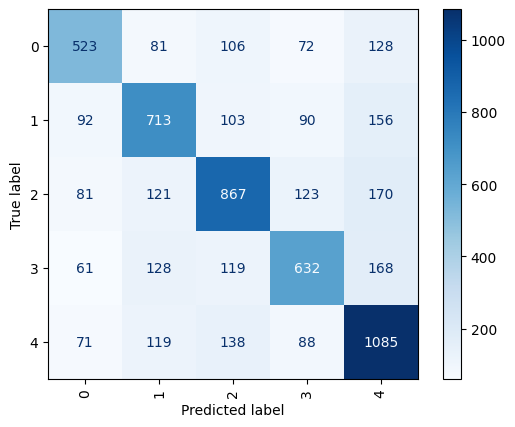

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import torch

def compute_confusion_matrix(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(test_dataloader, position=0, leave=True)):
            inputs = img_label['img']
            labels = img_label['label']
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return confusion_mat, accuracy, f1


confusion_mat, accuracy, f1= compute_confusion_matrix(model, test_dataloader)
labels = [0, 1, 2, 3, 4]
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=labels)
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
print(f"Accuracy: {accuracy}")
print(f"F1: {f1}")